In [1]:
from ultralytics import YOLO
import os
import cv2
from PIL import Image
import shutil
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import pandas as pd
import re
import torch; print(torch.cuda.is_available())


True


In [2]:
images_dir = "C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/cars_dataset/Images"
ann_dir = "C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/cars_dataset/Annotations"
imagesets_dir = "C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/cars_dataset/ImageSets"


In [3]:
# Create the output directory if it doesn't exist
output_dir = "C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/cars_dataset_yolo"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# create the images and labels directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

In [5]:
# convert the annotations to YOLO format
def convert_to_yolo(x1, y1, x2, y2, img_w, img_h):
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height


In [6]:
# Iterate through the splits and copy images and annotations
for split in ['train', 'val', 'test']:
    with open(os.path.join(imagesets_dir, f"{split}.txt")) as f:
        lines = f.read().splitlines()
    
    for name in lines:
        # Copy the image
        src_img = os.path.join(images_dir, f"{name}.png")
        dst_img = os.path.join(output_dir, 'images', split, f"{name}.png")
        shutil.copy2(src_img, dst_img)

        # Open the image to get its dimensions
        img = Image.open(src_img)
        w, h = img.size

        # Copy the annotation file
        ann_file = os.path.join(ann_dir, f"{name}.txt")
        dst_label = os.path.join(output_dir, 'labels', split, f"{name}.txt")
        with open(ann_file, 'r') as af, open(dst_label, 'w') as yf:
            for line in af:
                x1, y1, x2, y2, cls = map(int, line.strip().split())
                x_c, y_c, width, height = convert_to_yolo(x1, y1, x2, y2, w, h)
                yf.write(f"0 {x_c:.6f} {y_c:.6f} {width:.6f} {height:.6f}\n")

In [7]:
# create the data.yaml file
yaml_content = """
path: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/cars_dataset_yolo
train: images/train
val: images/val
test: images/test

names:
  0: car
"""
# write the yaml content to a file
with open("data.yaml", "w") as f:
    f.write(yaml_content)


In [8]:
# pre-trained model
model = YOLO('yolov8n.pt')  


In [40]:
def evaluate_model(model_path):
    model = YOLO(model_path)
    
    # === YOLO Metrics ===
    metrics = model.val(data='data.yaml', split='test')
    print("\n YOLO Val Metrics:")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")

    # Calculating Exact Match Accuracy and Normal Accuracy
    print("\n Calculating Counting Accuracy Metrics...")
    test_dir = 'cars_dataset_yolo/images/test'
    label_dir = 'cars_dataset_yolo/labels/test'
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]

    # Initialize variables
    exact_matches = 0
    total_preds = 0
    total_gts = 0 # ground truth (GT)
    sum_correct = 0  
    squared_errors = []

    for img_name in tqdm(test_images):
        img_path = os.path.join(test_dir, img_name)
        label_path = os.path.join(label_dir, img_name.replace('.png', '.txt'))

        gt_count = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                gt_count = len(f.readlines())

        preds = model.predict(img_path, verbose=False)
        pred_count = len(preds[0].boxes)

        if pred_count == gt_count:
            exact_matches += 1

        total_preds += pred_count
        total_gts += gt_count

        # Calculate the correct counts
        correct_count = min(pred_count, gt_count)
        sum_correct += correct_count

        squared_errors.append((pred_count - gt_count) ** 2)

    exact_acc = exact_matches / len(test_images) * 100 if len(test_images) > 0 else 0
    normal_acc_v2 = (sum_correct / total_gts * 100) if total_gts > 0 else 0
    mse = np.mean(squared_errors) if squared_errors else 0

    print(f"\n Exact Match Accuracy: {exact_acc:.2f}%")
    print(f" Normal Accuracy (Correct counts / GT counts): {normal_acc_v2:.2f}%")
    print(f" Mean Squared Error (MSE): {mse:.4f}")

In [10]:
# Visualize predictions
# Save predictions to a directory
# and visualize them

def visualize_predictions(model_path, save_dir='predictions'):
    model = YOLO(model_path)
    os.makedirs(save_dir, exist_ok=True)
    test_dir = 'cars_dataset_yolo/images/test'
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]
    for img_name in tqdm(test_images[:10], desc="Saving predictions"):
        img_path = os.path.join(test_dir, img_name)
        model(img_path, save=True, project=save_dir, name='examples', exist_ok=True)


General Main Function to Train the Model

In [11]:
# Train model 
def run_experiment(freeze_value, data_yaml='data.yaml', epochs=50, batch=16, imgsz=640):
    print(f"\n Training with freeze={freeze_value} blocks...")

    model = YOLO('yolov8n.pt')
    model.train(
        data=data_yaml,
        epochs=epochs,
        batch=batch,
        freeze=freeze_value,
        imgsz=imgsz,
        name=f"freeze_{freeze_value}",  # folders to save the results
        verbose=False
    )

    # find the last directory
    run_dir = f"C:/Users/YusufEmirComert/runs/detect/freeze_{freeze_value}"
    if not os.path.exists(run_dir):
        raise FileNotFoundError(f"Run directory not found: {run_dir}")

    # # Model Path
    best_model_path = os.path.join(run_dir, 'weights', 'best.pt')
    visualize_predictions(best_model_path)


TRAINING THE MODEL WITH 4 DIFFERENT FREEZE VALUES

In [12]:
# Freeze blocks and train
for freeze_val in [5, 10, 21, 0]:
    run_experiment(freeze_val)


 Training with freeze=5 blocks...
New https://pypi.org/project/ultralytics/8.3.139 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_52, n

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 151.334.4 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to C:\Users\YusufEmirComert\runs\detect\freeze_52\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\YusufEmirComert\runs\detect\freeze_52
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.32G       1.44      1.763      1.001       1118        640: 100%|██████████| 63/63 [03:20<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]


                   all        200      11906      0.934      0.938      0.957      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         5G      1.179     0.7423     0.9171        787        640: 100%|██████████| 63/63 [01:53<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

                   all        200      11906      0.968      0.946      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.95G      1.105     0.6588     0.9008        870        640: 100%|██████████| 63/63 [02:31<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.45s/it]

                   all        200      11906      0.985      0.959      0.987       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.38G      1.058     0.6159     0.8929        669        640: 100%|██████████| 63/63 [01:31<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.986      0.964       0.99      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.75G      1.029       0.59     0.8805        908        640: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        200      11906       0.99      0.969      0.991      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.23G      1.004     0.5728     0.8798        585        640: 100%|██████████| 63/63 [02:14<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        200      11906       0.99      0.971      0.992      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.05G     0.9813     0.5469     0.8725        922        640: 100%|██████████| 63/63 [01:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.988      0.974      0.992      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.65G      0.986     0.5499     0.8727        766        640: 100%|██████████| 63/63 [02:09<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

                   all        200      11906      0.989      0.975      0.993      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.19G     0.9566     0.5242     0.8684        900        640: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.992      0.975      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.32G     0.9376      0.513      0.864       1024        640: 100%|██████████| 63/63 [03:54<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]

                   all        200      11906      0.991      0.976      0.993      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.05G     0.9324     0.5029     0.8635        902        640: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]

                   all        200      11906      0.989      0.975      0.993      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.17G     0.9125     0.4934     0.8598        736        640: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        200      11906      0.989      0.978      0.993      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.82G      0.924     0.4954     0.8603       1119        640: 100%|██████████| 63/63 [01:51<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200      11906      0.991      0.976      0.993       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.94G     0.9017      0.482     0.8543        931        640: 100%|██████████| 63/63 [02:26<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        200      11906      0.991      0.977      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.78G     0.9106     0.4794     0.8566        983        640: 100%|██████████| 63/63 [01:33<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        200      11906      0.992      0.978      0.994      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.38G     0.8914     0.4701     0.8515       1080        640: 100%|██████████| 63/63 [01:42<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

                   all        200      11906      0.993      0.979      0.994      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.08G     0.8781     0.4631     0.8507        827        640: 100%|██████████| 63/63 [01:34<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        200      11906       0.99      0.981      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.05G     0.8805     0.4601     0.8507        843        640: 100%|██████████| 63/63 [02:11<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]

                   all        200      11906      0.993       0.98      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.44G     0.8808     0.4611     0.8503        718        640: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        200      11906      0.991      0.981      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.76G     0.8658     0.4549     0.8514        772        640: 100%|██████████| 63/63 [03:39<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        200      11906      0.993      0.981      0.994      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.96G     0.8529      0.445     0.8467        949        640: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        200      11906      0.993      0.979      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.37G     0.8604     0.4469     0.8467       1063        640: 100%|██████████| 63/63 [01:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        200      11906      0.991      0.984      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.73G     0.8559     0.4443     0.8474       1217        640: 100%|██████████| 63/63 [01:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        200      11906      0.992      0.981      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.53G     0.8441     0.4395     0.8452        502        640: 100%|██████████| 63/63 [03:35<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]

                   all        200      11906      0.992      0.982      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.64G     0.8371     0.4368     0.8418        857        640: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.991      0.984      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.17G     0.8509     0.4416      0.845        986        640: 100%|██████████| 63/63 [01:42<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        200      11906      0.991      0.985      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.19G     0.8352     0.4336     0.8459        908        640: 100%|██████████| 63/63 [02:44<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        200      11906      0.992      0.984      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.61G     0.8499     0.4351     0.8452        914        640: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.989      0.985      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.79G     0.8371     0.4279     0.8433        730        640: 100%|██████████| 63/63 [01:34<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.992      0.984      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.33G     0.8345     0.4248     0.8414        709        640: 100%|██████████| 63/63 [01:51<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.993      0.983      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.2G     0.8268     0.4221     0.8391       1028        640: 100%|██████████| 63/63 [04:50<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.07s/it]

                   all        200      11906      0.992      0.984      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.54G     0.8105     0.4146     0.8402        797        640: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.992      0.984      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.13G     0.8197     0.4198     0.8399        935        640: 100%|██████████| 63/63 [01:58<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200      11906       0.99      0.985      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.54G     0.8088     0.4148     0.8379       1109        640: 100%|██████████| 63/63 [01:28<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        200      11906      0.994      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.74G     0.8157     0.4123     0.8389        949        640: 100%|██████████| 63/63 [03:40<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.11s/it]

                   all        200      11906      0.992      0.984      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.53G     0.8057     0.4099     0.8345        800        640: 100%|██████████| 63/63 [01:33<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        200      11906      0.994      0.983      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.62G     0.8008      0.408     0.8378        895        640: 100%|██████████| 63/63 [04:12<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.63s/it]

                   all        200      11906      0.992      0.984      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.73G     0.8014     0.4059     0.8367        863        640: 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.991      0.985      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.02G     0.8031     0.4055     0.8346       1134        640: 100%|██████████| 63/63 [01:30<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200      11906      0.994      0.983      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.17G     0.7928     0.4025     0.8351        719        640: 100%|██████████| 63/63 [01:57<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.992      0.985      0.994      0.823


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.97G     0.7516     0.3875     0.8322        667        640: 100%|██████████| 63/63 [01:20<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]

                   all        200      11906       0.99      0.985      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.22G     0.7413     0.3775     0.8301        629        640: 100%|██████████| 63/63 [01:16<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

                   all        200      11906      0.993      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.6G     0.7419     0.3774     0.8296        500        640: 100%|██████████| 63/63 [01:13<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        200      11906      0.992      0.986      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.36G     0.7372     0.3733     0.8289        441        640: 100%|██████████| 63/63 [01:17<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.98s/it]

                   all        200      11906      0.993      0.986      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.59G     0.7314     0.3694     0.8293        447        640: 100%|██████████| 63/63 [01:19<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        200      11906      0.991      0.986      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.6G     0.7229     0.3659     0.8264        444        640: 100%|██████████| 63/63 [01:37<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.20s/it]

                   all        200      11906      0.991      0.987      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.19G     0.7184     0.3622     0.8277        431        640: 100%|██████████| 63/63 [01:12<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        200      11906      0.993      0.985      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.73G     0.7146     0.3598     0.8258        712        640: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        200      11906      0.993      0.986      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.7132     0.3586      0.826        601        640: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.993      0.985      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.44G     0.7121     0.3572     0.8242        611        640: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        200      11906      0.992      0.986      0.994      0.834



50 epochs completed in 1.840 hours.
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_52\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_52\weights\best.pt, 6.2MB

Validating C:\Users\YusufEmirComert\runs\detect\freeze_52\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


                   all        200      11906      0.992      0.986      0.994      0.834
Speed: 1.1ms preprocess, 10.3ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\freeze_52


Saving predictions:   0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00008.png: 384x640 12 cars, 78.2ms
Speed: 4.0ms preprocess, 78.2ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  10%|█         | 1/10 [00:00<00:04,  2.07it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00017.png: 384x640 52 cars, 28.4ms
Speed: 4.1ms preprocess, 28.4ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  20%|██        | 2/10 [00:00<00:02,  3.64it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00019.png: 384x640 58 cars, 28.7ms
Speed: 3.6ms preprocess, 28.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  30%|███       | 3/10 [00:00<00:01,  4.79it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00021.png: 384x640 49 cars, 28.9ms
Speed: 3.8ms preprocess, 28.9ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  40%|████      | 4/10 [00:00<00:01,  5.84it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00033.png: 384x640 12 cars, 29.1ms
Speed: 4.0ms preprocess, 29.1ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00036.png: 384x640 12 cars, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  60%|██████    | 6/10 [00:01<00:00,  8.19it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00055.png: 384x640 41 cars, 29.6ms
Speed: 3.9ms preprocess, 29.6ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  70%|███████   | 7/10 [00:01<00:00,  8.38it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00058.png: 384x640 43 cars, 29.8ms
Speed: 3.8ms preprocess, 29.8ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  80%|████████  | 8/10 [00:01<00:00,  8.26it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00073.png: 384x640 38 cars, 29.0ms
Speed: 3.7ms preprocess, 29.0ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  90%|█████████ | 9/10 [00:01<00:00,  8.55it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00078.png: 384x640 52 cars, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


 Training with freeze=10 blocks...


New https://pypi.org/project/ultralytics/8.3.139 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_102, nbs=64, nms=False, opset=None, opt

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 1442.9867.1 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to C:\Users\YusufEmirComert\runs\detect\freeze_102\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\YusufEmirComert\runs\detect\freeze_102
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.13G      1.465      1.813      1.011       1118        640: 100%|██████████| 63/63 [04:26<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.84s/it]

                   all        200      11906      0.921      0.925      0.956      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.83G        1.2     0.7649     0.9223        787        640: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        200      11906      0.966      0.934      0.976      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.77G      1.137     0.6819     0.9077        870        640: 100%|██████████| 63/63 [01:22<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.978      0.954       0.98      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.2G      1.078     0.6338     0.8971        669        640: 100%|██████████| 63/63 [03:01<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

                   all        200      11906      0.983       0.96      0.987      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.56G      1.055     0.6061     0.8855        908        640: 100%|██████████| 63/63 [01:34<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        200      11906      0.985      0.965      0.989      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.05G      1.023     0.5865     0.8835        585        640: 100%|██████████| 63/63 [03:56<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

                   all        200      11906       0.99      0.963      0.991      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.86G      1.007     0.5637     0.8778        922        640: 100%|██████████| 63/63 [01:21<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        200      11906      0.987       0.97      0.992       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.46G     0.9967     0.5576     0.8745        766        640: 100%|██████████| 63/63 [02:00<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

                   all        200      11906      0.986      0.972      0.992      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         5G     0.9962     0.5475     0.8755        900        640: 100%|██████████| 63/63 [01:27<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        200      11906      0.989       0.97      0.992      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.14G      0.974     0.5367     0.8706       1024        640: 100%|██████████| 63/63 [02:11<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]

                   all        200      11906      0.988      0.973      0.992      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.87G     0.9477     0.5179     0.8657        902        640: 100%|██████████| 63/63 [01:29<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.988      0.974      0.992      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.99G     0.9499      0.514      0.866        736        640: 100%|██████████| 63/63 [01:29<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        200      11906      0.987      0.972      0.993      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.63G     0.9515     0.5138     0.8654       1119        640: 100%|██████████| 63/63 [01:19<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.989      0.974      0.993      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.76G     0.9392     0.5002      0.861        931        640: 100%|██████████| 63/63 [02:08<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]

                   all        200      11906      0.992      0.975      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.44G     0.9289     0.4958     0.8602        983        640: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.991      0.976      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.19G     0.9243     0.4906     0.8574       1080        640: 100%|██████████| 63/63 [01:26<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        200      11906      0.989      0.977      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.89G     0.9155     0.4851      0.857        827        640: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        200      11906      0.992      0.976      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.88G     0.9177     0.4841     0.8572        843        640: 100%|██████████| 63/63 [02:40<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

                   all        200      11906      0.987       0.98      0.993      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.26G      0.908     0.4809      0.855        718        640: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


                   all        200      11906       0.99      0.978      0.993       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.58G     0.9028     0.4778     0.8571        772        640: 100%|██████████| 63/63 [02:13<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


                   all        200      11906       0.99      0.979      0.994      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.77G     0.8976     0.4706     0.8531        949        640: 100%|██████████| 63/63 [02:29<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.991       0.98      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.19G     0.8922     0.4659     0.8527       1063        640: 100%|██████████| 63/63 [01:51<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]

                   all        200      11906       0.99      0.978      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.55G     0.8947     0.4654     0.8531       1217        640: 100%|██████████| 63/63 [01:57<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906       0.99       0.98      0.994      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.34G     0.8876     0.4629     0.8523        502        640: 100%|██████████| 63/63 [01:49<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.989       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.46G     0.8846     0.4621     0.8496        857        640: 100%|██████████| 63/63 [07:48<00:00,  7.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

                   all        200      11906      0.989      0.981      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.99G     0.8904     0.4651     0.8515        986        640: 100%|██████████| 63/63 [02:10<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        200      11906      0.988      0.982      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         5G     0.8758     0.4555     0.8526        908        640: 100%|██████████| 63/63 [01:37<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200      11906      0.991       0.98      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.43G     0.8841     0.4575     0.8505        914        640: 100%|██████████| 63/63 [05:08<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]

                   all        200      11906      0.992      0.979      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.61G     0.8693     0.4488      0.849        730        640: 100%|██████████| 63/63 [01:55<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.989      0.982      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.15G     0.8731     0.4501     0.8483        709        640: 100%|██████████| 63/63 [03:48<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.38s/it]

                   all        200      11906      0.991       0.98      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.02G     0.8745     0.4503     0.8468       1028        640: 100%|██████████| 63/63 [01:51<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200      11906      0.991       0.98      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.36G      0.861     0.4418     0.8482        797        640: 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]

                   all        200      11906      0.992      0.979      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.95G     0.8644      0.445     0.8471        935        640: 100%|██████████| 63/63 [02:22<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

                   all        200      11906      0.991      0.982      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.36G     0.8566     0.4408     0.8455       1109        640: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.991       0.98      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.55G     0.8642     0.4408     0.8464        949        640: 100%|██████████| 63/63 [02:14<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

                   all        200      11906      0.991      0.982      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.35G     0.8581     0.4394     0.8427        800        640: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        200      11906       0.99      0.983      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.43G     0.8447     0.4337     0.8448        895        640: 100%|██████████| 63/63 [06:55<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:36<00:00,  5.16s/it]

                   all        200      11906       0.99      0.983      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.55G     0.8509     0.4342     0.8444        863        640: 100%|██████████| 63/63 [03:56<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.70s/it]

                   all        200      11906      0.991      0.982      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.83G     0.8563      0.433     0.8428       1134        640: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        200      11906      0.991      0.983      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.98G     0.8424     0.4294     0.8431        719        640: 100%|██████████| 63/63 [02:10<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        200      11906      0.992      0.982      0.994      0.811


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.79G     0.7898     0.4119     0.8385        667        640: 100%|██████████| 63/63 [01:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.00s/it]

                   all        200      11906      0.992      0.982      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.04G     0.7798     0.4026     0.8359        629        640: 100%|██████████| 63/63 [01:17<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all        200      11906      0.991      0.984      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.42G     0.7812     0.4005     0.8358        500        640: 100%|██████████| 63/63 [01:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.32s/it]

                   all        200      11906      0.992      0.984      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.17G     0.7814     0.3985     0.8357        441        640: 100%|██████████| 63/63 [01:13<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.04s/it]

                   all        200      11906      0.992      0.983      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.41G     0.7771     0.3947     0.8366        447        640: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]

                   all        200      11906      0.992      0.983      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.42G     0.7669     0.3903     0.8333        444        640: 100%|██████████| 63/63 [01:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]

                   all        200      11906      0.993      0.983      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         3G     0.7619     0.3876     0.8343        431        640: 100%|██████████| 63/63 [01:19<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.31s/it]

                   all        200      11906      0.992      0.983      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.54G     0.7602     0.3862      0.833        712        640: 100%|██████████| 63/63 [01:35<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        200      11906      0.993      0.983      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.19G     0.7599     0.3851     0.8329        601        640: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]

                   all        200      11906      0.993      0.983      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.27G     0.7591      0.383     0.8314        611        640: 100%|██████████| 63/63 [01:35<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        200      11906      0.992      0.984      0.994      0.819



50 epochs completed in 2.072 hours.
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_102\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_102\weights\best.pt, 6.2MB

Validating C:\Users\YusufEmirComert\runs\detect\freeze_102\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


                   all        200      11906      0.992      0.984      0.994       0.82
Speed: 0.5ms preprocess, 5.5ms inference, 0.0ms loss, 26.9ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\freeze_102


Saving predictions:   0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00008.png: 384x640 12 cars, 35.0ms
Speed: 3.6ms preprocess, 35.0ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  10%|█         | 1/10 [00:00<00:03,  2.43it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00017.png: 384x640 51 cars, 19.7ms
Speed: 3.6ms preprocess, 19.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00019.png: 384x640 58 cars, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  30%|███       | 3/10 [00:00<00:01,  5.98it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00021.png: 384x640 50 cars, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00033.png: 384x640 13 cars, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  50%|█████     | 5/10 [00:00<00:00,  8.75it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00036.png: 384x640 13 cars, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00055.png: 384x640 43 cars, 14.0ms
Speed: 2.5ms preprocess, 14.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  70%|███████   | 7/10 [00:00<00:00, 10.74it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00058.png: 384x640 40 cars, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00073.png: 384x640 38 cars, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  90%|█████████ | 9/10 [00:00<00:00, 12.24it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00078.png: 384x640 52 cars, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions: 100%|██████████| 10/10 [00:01<00:00,  9.80it/s]


 Training with freeze=21 blocks...


New https://pypi.org/project/ultralytics/8.3.139 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=21, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_212, nbs=64, nms=False, opset=None, opt

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1476.4899.1 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to C:\Users\YusufEmirComert\runs\detect\freeze_212\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\YusufEmirComert\runs\detect\freeze_212
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.79G       1.57      2.093      1.084       1118        640: 100%|██████████| 63/63 [02:24<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all        200      11906      0.808      0.831       0.88      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.51G      1.391      1.008       1.01        787        640: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        200      11906       0.87      0.872      0.923      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.43G      1.335     0.8958     0.9968        870        640: 100%|██████████| 63/63 [01:37<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.45s/it]

                   all        200      11906      0.894      0.877      0.936      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.86G      1.282     0.8232     0.9863        669        640: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


                   all        200      11906      0.934      0.895      0.955      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.22G      1.258     0.7858     0.9701        908        640: 100%|██████████| 63/63 [01:56<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]

                   all        200      11906       0.95      0.922      0.964      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.71G      1.237     0.7699     0.9708        585        640: 100%|██████████| 63/63 [03:24<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


                   all        200      11906      0.956       0.92      0.968      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.53G      1.222     0.7449     0.9618        922        640: 100%|██████████| 63/63 [02:02<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        200      11906      0.953      0.926      0.968      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.13G      1.218      0.743      0.961        766        640: 100%|██████████| 63/63 [01:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


                   all        200      11906      0.951      0.918      0.967      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.66G      1.199     0.7246     0.9567        900        640: 100%|██████████| 63/63 [03:29<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.26s/it]

                   all        200      11906      0.958      0.923      0.971      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       5.8G      1.196     0.7222     0.9542       1024        640: 100%|██████████| 63/63 [01:51<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        200      11906      0.949      0.933       0.97      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.53G      1.184     0.7059     0.9525        902        640: 100%|██████████| 63/63 [02:29<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]

                   all        200      11906      0.954      0.928      0.971      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.65G      1.181     0.7051     0.9511        736        640: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]

                   all        200      11906      0.963       0.93      0.974      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.3G      1.188     0.7017     0.9501       1119        640: 100%|██████████| 63/63 [01:28<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        200      11906      0.966      0.923      0.973      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.42G      1.181      0.693     0.9456        931        640: 100%|██████████| 63/63 [02:22<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]

                   all        200      11906       0.97      0.922      0.974      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       4.1G      1.174     0.6927     0.9472        983        640: 100%|██████████| 63/63 [01:42<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        200      11906      0.959      0.931      0.974      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.85G      1.173     0.6881     0.9417       1080        640: 100%|██████████| 63/63 [01:33<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        200      11906      0.961      0.934      0.974      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.55G      1.164     0.6805     0.9416        827        640: 100%|██████████| 63/63 [01:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        200      11906      0.967      0.934      0.976      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.54G      1.166     0.6799     0.9424        843        640: 100%|██████████| 63/63 [02:34<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]

                   all        200      11906      0.959      0.936      0.974      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.92G       1.15     0.6703     0.9381        718        640: 100%|██████████| 63/63 [01:30<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.965      0.934      0.977      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.24G      1.145     0.6748     0.9434        772        640: 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


                   all        200      11906      0.968      0.937      0.978      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.43G      1.136     0.6599     0.9353        949        640: 100%|██████████| 63/63 [01:34<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        200      11906      0.971      0.935      0.978      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.85G       1.14     0.6633     0.9372       1063        640: 100%|██████████| 63/63 [01:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        200      11906      0.969      0.932      0.978      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.21G      1.137     0.6586     0.9368       1217        640: 100%|██████████| 63/63 [01:20<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        200      11906      0.964       0.94      0.978      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.01G      1.145     0.6601     0.9375        502        640: 100%|██████████| 63/63 [01:47<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


                   all        200      11906      0.968      0.937       0.98      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.12G      1.141     0.6544     0.9336        857        640: 100%|██████████| 63/63 [02:02<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        200      11906      0.972      0.943       0.98       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.65G      1.154     0.6623     0.9389        986        640: 100%|██████████| 63/63 [01:51<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]

                   all        200      11906      0.966      0.937       0.98      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.66G      1.131     0.6534     0.9409        908        640: 100%|██████████| 63/63 [04:03<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

                   all        200      11906      0.969      0.943      0.979      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.09G      1.135      0.656     0.9343        914        640: 100%|██████████| 63/63 [01:47<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.969      0.943      0.981      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.27G      1.129     0.6472     0.9344        730        640: 100%|██████████| 63/63 [02:20<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]

                   all        200      11906       0.97      0.942      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.82G      1.135     0.6483     0.9337        709        640: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        200      11906      0.967       0.94       0.98      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.68G       1.14     0.6472      0.931       1028        640: 100%|██████████| 63/63 [03:46<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:34<00:00,  4.92s/it]

                   all        200      11906      0.967      0.939       0.98      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.02G      1.119     0.6406     0.9341        797        640: 100%|██████████| 63/63 [01:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.971      0.943      0.981      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.61G      1.129     0.6458     0.9332        935        640: 100%|██████████| 63/63 [01:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.972      0.945      0.981      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.02G      1.124     0.6411     0.9304       1109        640: 100%|██████████| 63/63 [02:32<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]

                   all        200      11906       0.97      0.947      0.982      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.22G      1.129     0.6403     0.9311        949        640: 100%|██████████| 63/63 [02:16<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        200      11906       0.97      0.944      0.982      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.01G      1.127      0.638     0.9264        800        640: 100%|██████████| 63/63 [01:32<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        200      11906      0.972      0.941      0.982      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.1G      1.116     0.6365     0.9302        895        640: 100%|██████████| 63/63 [02:48<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.11s/it]

                   all        200      11906      0.972      0.944      0.983      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.21G      1.118     0.6346      0.929        863        640: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        200      11906      0.972      0.943      0.982      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.5G      1.122     0.6349     0.9257       1134        640: 100%|██████████| 63/63 [01:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.971      0.944      0.983      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.64G      1.115     0.6347     0.9279        719        640: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.973      0.945      0.981      0.722


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.45G      1.036     0.6115     0.9261        667        640: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]

                   all        200      11906      0.971      0.947      0.981      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.7G      1.029     0.6014     0.9235        629        640: 100%|██████████| 63/63 [01:08<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        200      11906      0.971      0.946      0.983      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.08G      1.028     0.5987     0.9218        500        640: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


                   all        200      11906      0.974      0.942      0.983      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.84G      1.025     0.5951     0.9221        441        640: 100%|██████████| 63/63 [01:15<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


                   all        200      11906      0.971      0.944      0.982      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.07G      1.025     0.5938     0.9242        447        640: 100%|██████████| 63/63 [01:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]

                   all        200      11906      0.972      0.948      0.983      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.08G      1.018     0.5915     0.9209        444        640: 100%|██████████| 63/63 [01:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

                   all        200      11906      0.972      0.948      0.983      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.67G      1.009      0.589     0.9212        431        640: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        200      11906      0.972      0.948      0.983      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.21G      1.012     0.5887     0.9209        712        640: 100%|██████████| 63/63 [01:01<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.974      0.947      0.984      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.85G      1.009     0.5864     0.9196        601        640: 100%|██████████| 63/63 [01:01<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        200      11906      0.974      0.946      0.983      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.93G      1.012     0.5866     0.9169        611        640: 100%|██████████| 63/63 [01:01<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        200      11906      0.974      0.946      0.983       0.73



50 epochs completed in 1.723 hours.
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_212\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_212\weights\best.pt, 6.2MB

Validating C:\Users\YusufEmirComert\runs\detect\freeze_212\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


                   all        200      11906      0.975      0.946      0.983      0.731
Speed: 1.5ms preprocess, 11.4ms inference, 0.0ms loss, 18.0ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\freeze_212


Saving predictions:   0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00008.png: 384x640 14 cars, 14.9ms
Speed: 2.5ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  10%|█         | 1/10 [00:00<00:03,  2.95it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00017.png: 384x640 59 cars, 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00019.png: 384x640 61 cars, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  30%|███       | 3/10 [00:00<00:00,  7.07it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00021.png: 384x640 52 cars, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00033.png: 384x640 20 cars, 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  50%|█████     | 5/10 [00:00<00:00, 10.18it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00036.png: 384x640 25 cars, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00055.png: 384x640 49 cars, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  70%|███████   | 7/10 [00:00<00:00, 12.23it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00058.png: 384x640 45 cars, 13.2ms
Speed: 3.8ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00073.png: 384x640 41 cars, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  90%|█████████ | 9/10 [00:00<00:00, 13.31it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00078.png: 384x640 59 cars, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions: 100%|██████████| 10/10 [00:00<00:00, 10.90it/s]


 Training with freeze=0 blocks...


New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_02, nbs=64, nms=False, opset=None, optim

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1497.5755.5 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to C:\Users\YusufEmirComert\runs\detect\freeze_02\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\YusufEmirComert\runs\detect\freeze_02
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.06G      1.352      1.716     0.9777       1118        640: 100%|██████████| 63/63 [04:33<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.46s/it]

                   all        200      11906      0.959      0.924      0.963      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.75G      1.092     0.6921     0.8985        787        640: 100%|██████████| 63/63 [04:02<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]

                   all        200      11906      0.967      0.944      0.976      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.7G      1.059     0.6269     0.8897        870        640: 100%|██████████| 63/63 [02:38<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        200      11906      0.981      0.956      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.13G     0.9789     0.5803     0.8768        669        640: 100%|██████████| 63/63 [02:40<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.55s/it]

                   all        200      11906      0.989      0.964      0.991      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.49G     0.9692     0.5596     0.8685        908        640: 100%|██████████| 63/63 [03:04<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]

                   all        200      11906      0.988      0.974      0.992      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.97G     0.9286     0.5328      0.865        585        640: 100%|██████████| 63/63 [04:02<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        200      11906       0.99       0.97      0.992      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.79G     0.9162     0.5157     0.8608        922        640: 100%|██████████| 63/63 [03:54<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


                   all        200      11906      0.991      0.976      0.993      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.39G     0.9137     0.5126     0.8595        766        640: 100%|██████████| 63/63 [03:10<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


                   all        200      11906      0.992      0.977      0.993      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.93G      0.904     0.4966     0.8587        900        640: 100%|██████████| 63/63 [07:21<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.75s/it]

                   all        200      11906      0.991      0.979      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.06G     0.8792      0.482     0.8536       1024        640: 100%|██████████| 63/63 [02:50<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        200      11906      0.991       0.98      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       5.8G     0.8655     0.4692     0.8514        902        640: 100%|██████████| 63/63 [07:28<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:48<00:00,  6.97s/it]

                   all        200      11906      0.991      0.978      0.994      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.92G     0.8557     0.4639       0.85        736        640: 100%|██████████| 63/63 [03:28<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.73s/it]

                   all        200      11906      0.993      0.979      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.56G     0.8573     0.4612     0.8498       1119        640: 100%|██████████| 63/63 [02:46<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        200      11906      0.993      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.71G     0.8425     0.4494     0.8444        931        640: 100%|██████████| 63/63 [04:06<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]

                   all        200      11906      0.993      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.37G      0.841     0.4454     0.8452        983        640: 100%|██████████| 63/63 [03:54<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


                   all        200      11906      0.993      0.981      0.994      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.12G     0.8289     0.4378     0.8417       1080        640: 100%|██████████| 63/63 [03:28<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.11s/it]

                   all        200      11906      0.994      0.979      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.82G     0.8212     0.4325     0.8417        827        640: 100%|██████████| 63/63 [03:13<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

                   all        200      11906      0.991      0.982      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       5.8G     0.8298     0.4316     0.8429        843        640: 100%|██████████| 63/63 [03:13<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        200      11906      0.991      0.983      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.19G     0.8258     0.4309     0.8408        718        640: 100%|██████████| 63/63 [03:18<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]

                   all        200      11906      0.991      0.985      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.5G     0.8051     0.4244     0.8414        772        640: 100%|██████████| 63/63 [03:33<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        200      11906      0.993      0.983      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       5.7G     0.7904     0.4136      0.837        949        640: 100%|██████████| 63/63 [02:54<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        200      11906      0.993      0.983      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.11G     0.8092     0.4201     0.8384       1063        640: 100%|██████████| 63/63 [03:24<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.35s/it]

                   all        200      11906      0.993      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.47G     0.8026     0.4146     0.8388       1217        640: 100%|██████████| 63/63 [02:40<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        200      11906      0.994      0.981      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.27G     0.7885     0.4094     0.8369        502        640: 100%|██████████| 63/63 [03:35<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        200      11906      0.991      0.984      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.38G     0.7803     0.4045     0.8329        857        640: 100%|██████████| 63/63 [03:11<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        200      11906      0.992      0.984      0.994      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.91G     0.7915     0.4075     0.8363        986        640: 100%|██████████| 63/63 [02:49<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        200      11906      0.992      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.93G     0.7778     0.4032     0.8366        908        640: 100%|██████████| 63/63 [02:43<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        200      11906      0.993      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.35G     0.7762     0.3972      0.834        914        640: 100%|██████████| 63/63 [03:27<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]

                   all        200      11906      0.992      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.54G     0.7786     0.3943     0.8351        730        640: 100%|██████████| 63/63 [03:00<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]

                   all        200      11906      0.993      0.985      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.08G     0.7743     0.3907     0.8327        709        640: 100%|██████████| 63/63 [02:52<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


                   all        200      11906      0.996      0.983      0.994      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.94G     0.7816     0.3945     0.8321       1028        640: 100%|██████████| 63/63 [03:15<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.993      0.986      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.29G     0.7631     0.3847     0.8332        797        640: 100%|██████████| 63/63 [04:21<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]

                   all        200      11906      0.994      0.984      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.87G      0.764     0.3864     0.8318        935        640: 100%|██████████| 63/63 [02:38<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]

                   all        200      11906      0.994      0.985      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.28G     0.7562     0.3831     0.8304       1109        640: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.70s/it]

                   all        200      11906      0.994      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.48G      0.759     0.3815     0.8306        949        640: 100%|██████████| 63/63 [03:34<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]

                   all        200      11906      0.995      0.984      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.28G     0.7526     0.3813     0.8275        800        640: 100%|██████████| 63/63 [02:48<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        200      11906      0.993      0.985      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.71G     0.7461     0.3804     0.8296        895        640: 100%|██████████| 63/63 [03:30<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.91s/it]

                   all        200      11906      0.994      0.985      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.47G     0.7423     0.3765     0.8285        863        640: 100%|██████████| 63/63 [02:53<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


                   all        200      11906      0.994      0.985      0.994      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.76G     0.7479     0.3746     0.8268       1134        640: 100%|██████████| 63/63 [02:55<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        200      11906      0.993      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.91G     0.7414     0.3733      0.828        719        640: 100%|██████████| 63/63 [03:51<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200      11906      0.993      0.986      0.994      0.835


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.71G     0.7227     0.3703     0.8283        667        640: 100%|██████████| 63/63 [01:50<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.45s/it]

                   all        200      11906      0.993      0.985      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.96G     0.7082     0.3565     0.8254        629        640: 100%|██████████| 63/63 [01:58<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

                   all        200      11906      0.993      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.35G     0.7074      0.354     0.8251        500        640: 100%|██████████| 63/63 [02:01<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.43s/it]

                   all        200      11906      0.993      0.987      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       4.1G     0.7006     0.3494     0.8241        441        640: 100%|██████████| 63/63 [02:00<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.44s/it]

                   all        200      11906      0.995      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.34G     0.7025     0.3494     0.8262        447        640: 100%|██████████| 63/63 [02:02<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:44<00:00,  6.32s/it]


                   all        200      11906      0.994      0.987      0.994      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.34G     0.6866     0.3429     0.8219        444        640: 100%|██████████| 63/63 [02:53<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        200      11906      0.994      0.986      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.93G     0.6839     0.3385      0.823        431        640: 100%|██████████| 63/63 [01:44<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]

                   all        200      11906      0.995      0.986      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.47G     0.6824     0.3372     0.8214        712        640: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]

                   all        200      11906      0.994      0.987      0.994      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.12G     0.6772     0.3345     0.8213        601        640: 100%|██████████| 63/63 [01:54<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]

                   all        200      11906      0.994      0.987      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.19G     0.6743     0.3318      0.819        611        640: 100%|██████████| 63/63 [02:00<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.81s/it]

                   all        200      11906      0.994      0.987      0.994      0.846



50 epochs completed in 2.925 hours.
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_02\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\YusufEmirComert\runs\detect\freeze_02\weights\best.pt, 6.2MB

Validating C:\Users\YusufEmirComert\runs\detect\freeze_02\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


                   all        200      11906      0.994      0.987      0.994      0.846
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\freeze_02


Saving predictions:   0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00008.png: 384x640 12 cars, 18.7ms
Speed: 2.6ms preprocess, 18.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  10%|█         | 1/10 [00:00<00:04,  1.97it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00017.png: 384x640 52 cars, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00019.png: 384x640 58 cars, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  30%|███       | 3/10 [00:00<00:01,  5.35it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00021.png: 384x640 49 cars, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00033.png: 384x640 11 cars, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  50%|█████     | 5/10 [00:00<00:00,  8.12it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00036.png: 384x640 12 cars, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00055.png: 384x640 42 cars, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  70%|███████   | 7/10 [00:00<00:00, 10.33it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00058.png: 384x640 43 cars, 14.7ms
Speed: 4.5ms preprocess, 14.7ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples

image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00073.png: 384x640 40 cars, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions:  90%|█████████ | 9/10 [00:01<00:00, 11.60it/s]


image 1/1 c:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20160331_NTU_00078.png: 384x640 52 cars, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to predictions\examples


Saving predictions: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


Evaluating Results.

In [13]:
# Evaluate the models for each freeze value
freeze_vals = [5, 10, 21, 0]

for freeze in freeze_vals:
    print(f"\n Analyzing freeze={freeze} results...\n")
    run_dir = f"C:/Users/YusufEmirComert/runs/detect/freeze_{freeze}"


    # Evaluations
    best_model_path = os.path.join(run_dir, 'weights', 'best.pt')
    if os.path.exists(best_model_path):
        evaluate_model(best_model_path)
    else:
        print(f" best.pt has not found: {best_model_path}")



 Analyzing freeze=5 results...

Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 167.431.0 MB/s, size: 1383.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


                   all        200      13391      0.992      0.981      0.994      0.838
Speed: 0.7ms preprocess, 11.1ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val28

 YOLO Val Metrics:
Precision: 0.9919
Recall: 0.9814
mAP50: 0.9938
mAP50-95: 0.8375

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:08<00:00, 24.01it/s]



 Exact Match Accuracy: 39.50%
 Normal Accuracy (Correct counts / GT counts): 99.51%
 Mean Squared Error (MSE): 3.3850

 Analyzing freeze=10 results...

Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 4116.4487.1 MB/s, size: 1417.7 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


                   all        200      13391      0.991      0.978      0.994      0.823
Speed: 0.6ms preprocess, 4.0ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val29

 YOLO Val Metrics:
Precision: 0.9914
Recall: 0.9784
mAP50: 0.9937
mAP50-95: 0.8228

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 34.63it/s]


 Exact Match Accuracy: 43.50%
 Normal Accuracy (Correct counts / GT counts): 99.60%
 Mean Squared Error (MSE): 4.8850

 Analyzing freeze=21 results...

Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3801.4454.7 MB/s, size: 1514.9 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


                   all        200      13391      0.975      0.936      0.982      0.731
Speed: 0.9ms preprocess, 5.5ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val30

 YOLO Val Metrics:
Precision: 0.9745
Recall: 0.9363
mAP50: 0.9819
mAP50-95: 0.7312

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 34.42it/s]


 Exact Match Accuracy: 4.00%
 Normal Accuracy (Correct counts / GT counts): 99.81%
 Mean Squared Error (MSE): 111.7850

 Analyzing freeze=0 results...

Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3263.5627.6 MB/s, size: 1428.2 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:30<00:00,  2.33s/it]


                   all        200      13391      0.992      0.986      0.994       0.85
Speed: 2.3ms preprocess, 13.4ms inference, 0.1ms loss, 23.1ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val31

 YOLO Val Metrics:
Precision: 0.9921
Recall: 0.9863
mAP50: 0.9940
mAP50-95: 0.8502

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.11it/s]


 Exact Match Accuracy: 41.50%
 Normal Accuracy (Correct counts / GT counts): 99.55%
 Mean Squared Error (MSE): 2.3050


In [14]:
# Function to plot loss curves
def plot_loss_curves(run_dir, save_root):
    csv_path = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(csv_path):
        print(f"File NOT FOUND: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss (Train)')
    plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss (Train)')
    plt.plot(df['epoch'], df['val/box_loss'], label='Box Loss (Val)', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label='Class Loss (Val)', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: {os.path.basename(run_dir)}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # If not exist, create the directory
    os.makedirs(save_root, exist_ok=True)

    # Save the plot
    freeze_val = os.path.basename(run_dir).split('_')[-1]  # freeze_5 -> 5
    save_path = os.path.join(save_root, f'loss_curve_freeze_{freeze_val}.png')

    plt.savefig(save_path)
    print(f"Loss curve saved to: {save_path}")

    plt.show()

Loss curve for freeze=5:
Loss curve saved to: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\results\loss_curve_freeze_5.png


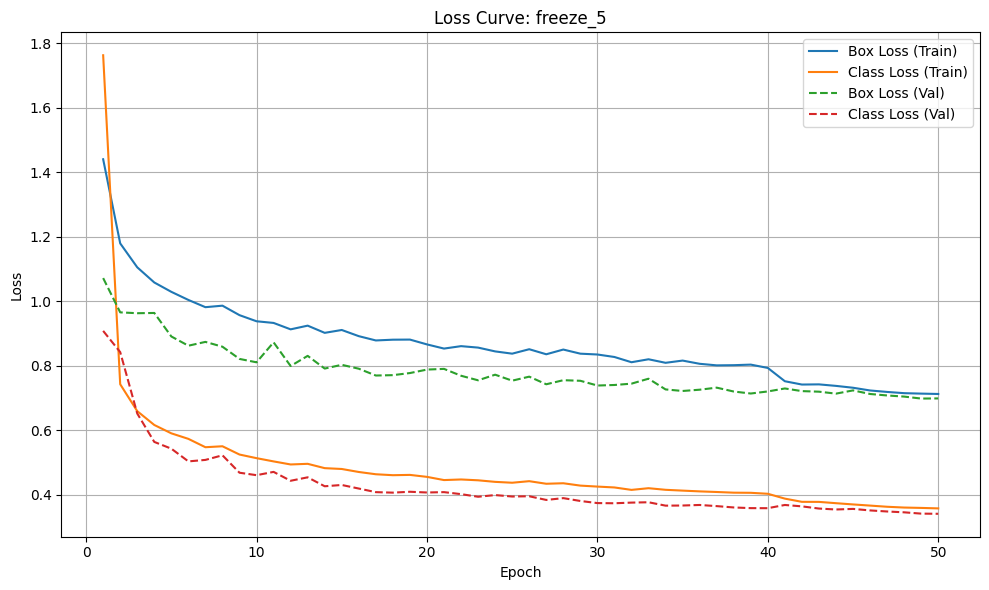

Loss curve for freeze=10:
Loss curve saved to: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\results\loss_curve_freeze_10.png


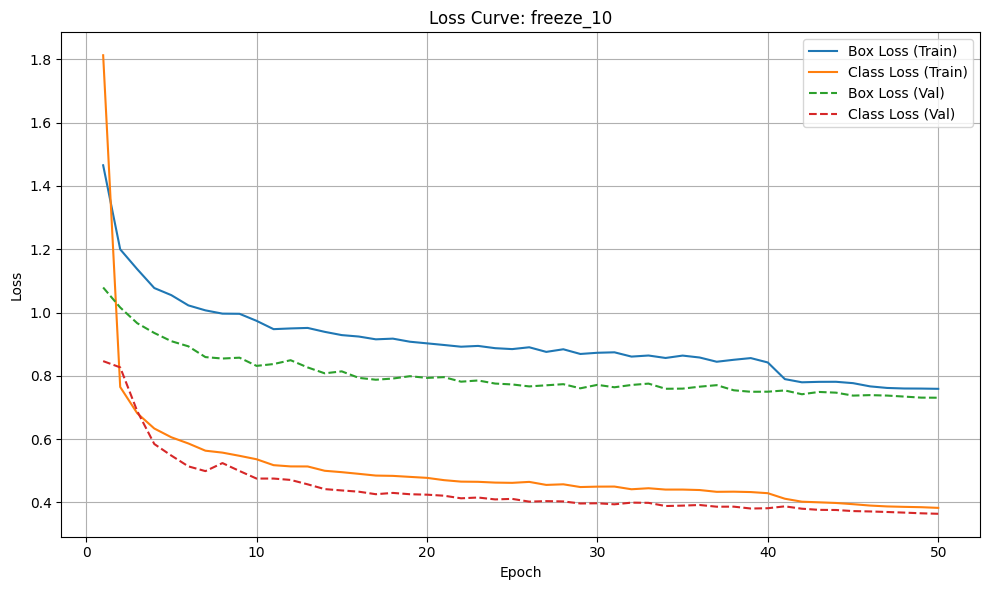

Loss curve for freeze=21:
Loss curve saved to: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\results\loss_curve_freeze_21.png


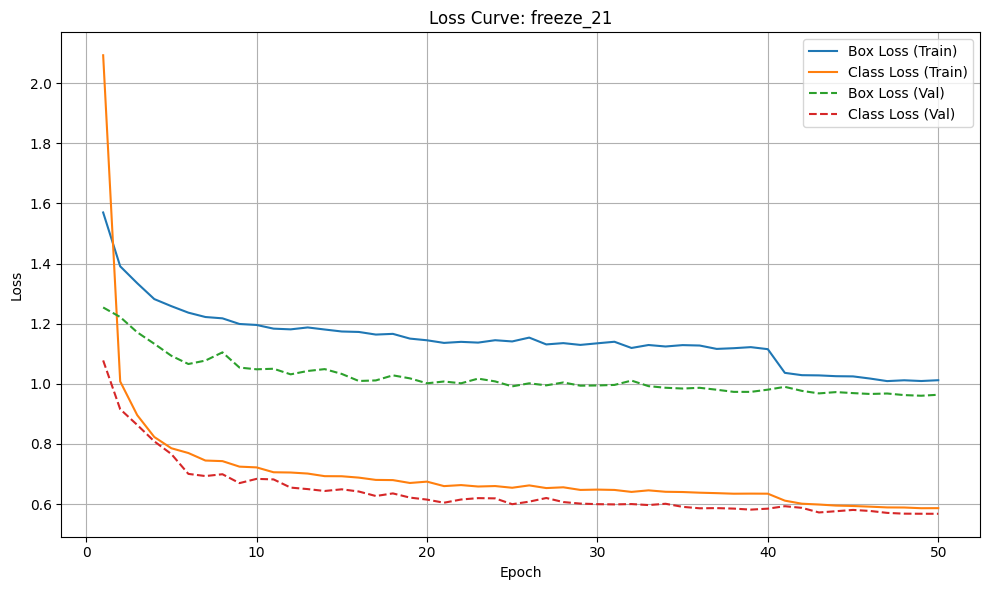

Loss curve for freeze=0:
Loss curve saved to: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\results\loss_curve_freeze_0.png


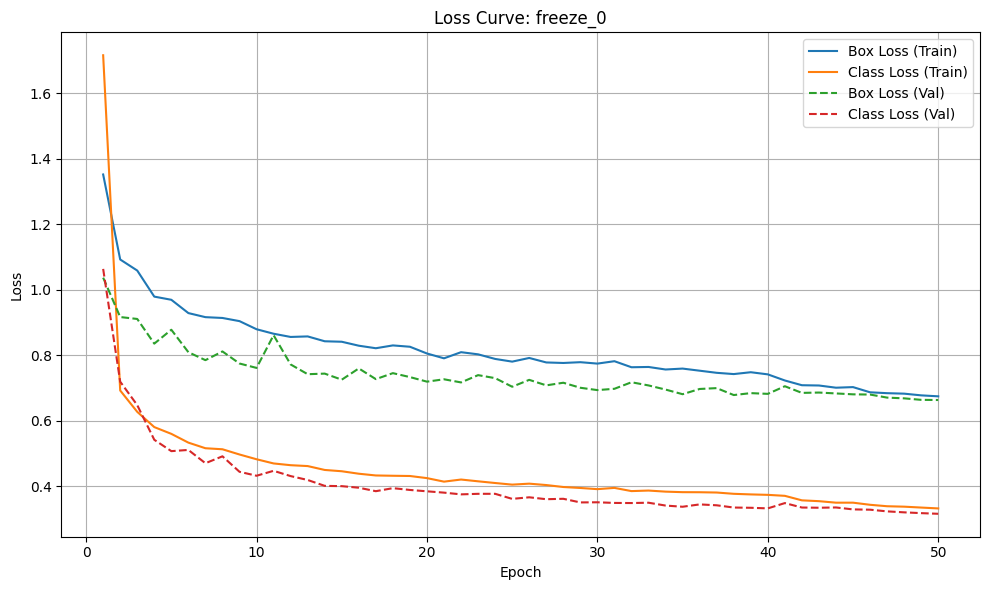

In [16]:
%matplotlib inline
# Run the loss curve plotting for each freeze value
freeze_vals = [5, 10, 21, 0]
save_root = r"C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\results"

for freeze in freeze_vals:
    run_dir = f"C:/Users/YusufEmirComert/runs/detect/freeze_{freeze}"
    print(f"Loss curve for freeze={freeze}:")
    plot_loss_curves(run_dir, save_root)


In [43]:
def run_experiment_custom(freeze_value, optimizer, lr, batch, imgsz, mosaic, epochs, data_yaml):
    run_name = f"freeze{freeze_value}_opt{optimizer}_lr{lr}_batch{batch}_mosaic{mosaic}_imgsz{imgsz}"
    project_dir = "runs/detect/"
    run_dir = os.path.join(project_dir, run_name)

    print(f"\nRunning: {run_name}")
    model = YOLO("yolov8n.pt")

    model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        lr0=lr,
        optimizer=optimizer,
        project=project_dir,
        name=run_name,
        freeze=freeze_value,
        mosaic=mosaic,
        device='cuda',
        workers=2,
        save=True,
        save_period=-1,
        verbose=True
    )

    best_model_path = os.path.join(run_dir, 'weights', 'best.pt')
    if not os.path.exists(best_model_path):
        print(f"!!Model not saved: {best_model_path}!!")
    else:
        print(f"Model saved at: {best_model_path}")


In [44]:
def run_general_hyperparam_tests():
    freeze = 10
    epochs = 25
    data_yaml = 'data.yaml'

    optimizers = ['AdamW', 'SGD']
    lrs = [0.005, 0.01]
    batches = [16, 32]
    imgsz = 640
    mosaic = False

    print("Running General Hyperparameter Tests...")
    for opt in optimizers:
        for lr in lrs:
            for batch in batches:
                run_experiment_custom(freeze_value=freeze, optimizer=opt, lr=lr, batch=batch, imgsz=imgsz, mosaic=mosaic, epochs=epochs, data_yaml=data_yaml)



In [45]:
def run_yolo_specific_hyperparam_tests():
    freeze = 10
    epochs = 25
    data_yaml = 'data.yaml'

    optimizer = 'AdamW'
    lr = 0.01
    batch = 32

    mosaics = [True, False]
    imgsizes = [640, 320]

    print("Running YOLO-specific Hyperparameter Tests...")
    for mosaic_flag in mosaics:
        for size in imgsizes:
            run_experiment_custom(freeze_value=freeze, optimizer=optimizer, lr=lr, batch=batch, imgsz=size, mosaic=mosaic_flag, epochs=epochs, data_yaml=data_yaml)


In [46]:
run_general_hyperparam_tests()


Running General Hyperparameter Tests...

Running: freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640
New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1172.7110.9 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      6.63G      1.301      1.323     0.9865        604        640: 100%|██████████| 63/63 [01:17<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


                   all        200      11906      0.951      0.915      0.961      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.43G       1.14     0.7418     0.9352        308        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906       0.97      0.932      0.975       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.43G      1.077     0.6575     0.9157        451        640: 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906      0.981      0.947      0.981      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.42G      1.059     0.6225     0.9129        369        640: 100%|██████████| 63/63 [00:11<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.983      0.955      0.985      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.42G     0.9973     0.5816     0.8995        490        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.983      0.963      0.987      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.42G     0.9802     0.5555     0.8905        386        640: 100%|██████████| 63/63 [00:11<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.987      0.964      0.989      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.42G      0.971     0.5441     0.8869        351        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200      11906      0.987      0.965      0.989      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.42G     0.9431       0.52     0.8818        452        640: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.989      0.965      0.991      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.42G      0.924     0.5018     0.8754        341        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906      0.989      0.971      0.992      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.42G     0.9181     0.5028      0.871        653        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906      0.988      0.972      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.42G     0.8995       0.48     0.8662        478        640: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.991      0.969      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.42G     0.8901     0.4728     0.8645        305        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906       0.99      0.972      0.992       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.42G      0.869     0.4581     0.8613        682        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906       0.99      0.974      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.42G     0.8663       0.45     0.8582        442        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906       0.99      0.976      0.992      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.42G     0.8644      0.445     0.8567        564        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.989      0.978      0.993        0.8


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.42G     0.8501     0.4391     0.8545        529        640: 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906       0.99      0.976      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.42G     0.8495     0.4336     0.8562        383        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906       0.99      0.975      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.42G     0.8518     0.4361     0.8543        419        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906       0.99      0.977      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.42G     0.8321     0.4221     0.8517        379        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906       0.99      0.977      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.42G     0.8214     0.4177     0.8493        317        640: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906      0.991      0.976      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.42G     0.8115     0.4088     0.8485        392        640: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.992      0.977      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.42G     0.8137     0.4094     0.8455        697        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906      0.992      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.42G     0.8012     0.4004     0.8446        493        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.991      0.978      0.993      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.42G     0.8019     0.3986     0.8437        586        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.993      0.977      0.993      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.42G     0.7919     0.3946     0.8426        558        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.991       0.98      0.994      0.814



25 epochs completed in 0.125 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


                   all        200      11906      0.993      0.977      0.993      0.815
Speed: 0.3ms preprocess, 1.7ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, f

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2966.6583.0 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      5.22G      1.371      1.633      1.009        620        640: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

                   all        200      11906      0.918       0.92      0.956      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.39G      1.149     0.7858     0.9485        271        640: 100%|██████████| 32/32 [01:08<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]

                   all        200      11906      0.922      0.917      0.954      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.82G      1.103     0.7012     0.9245        440        640: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

                   all        200      11906      0.962      0.952      0.976      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.67G      1.067     0.6439     0.9145        369        640: 100%|██████████| 32/32 [01:43<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]

                   all        200      11906      0.966      0.943       0.98      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.12G      1.002     0.6004     0.9005        537        640: 100%|██████████| 32/32 [00:49<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]

                   all        200      11906      0.972      0.958      0.982      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.81G     0.9767     0.5731     0.8915        396        640: 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

                   all        200      11906       0.98      0.963      0.985       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.19G     0.9509     0.5439     0.8834        356        640: 100%|██████████| 32/32 [01:04<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]

                   all        200      11906      0.987      0.969       0.99      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.13G     0.9331     0.5271     0.8799        460        640: 100%|██████████| 32/32 [00:54<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

                   all        200      11906      0.987      0.971      0.992      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.35G     0.9228     0.5132      0.876        365        640: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

                   all        200      11906       0.99      0.964      0.991       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.55G     0.9087     0.5003     0.8691        652        640: 100%|██████████| 32/32 [01:39<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

                   all        200      11906      0.987      0.971      0.992      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.28G      0.898     0.4886     0.8667        489        640: 100%|██████████| 32/32 [01:06<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]

                   all        200      11906      0.989       0.97      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       5.2G     0.8942     0.4804     0.8656        288        640: 100%|██████████| 32/32 [01:07<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        200      11906      0.991      0.973      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.17G     0.8772     0.4704     0.8632        637        640: 100%|██████████| 32/32 [01:00<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]

                   all        200      11906       0.99      0.971      0.992      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.58G     0.8668     0.4639     0.8607        428        640: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

                   all        200      11906      0.991       0.97      0.993      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.22G     0.8562     0.4542       0.86        526        640: 100%|██████████| 32/32 [01:02<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]

                   all        200      11906      0.992      0.975      0.993      0.795


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.47G     0.8476     0.4449     0.8546        497        640: 100%|██████████| 32/32 [01:43<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]

                   all        200      11906      0.989      0.977      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.13G      0.845     0.4407     0.8549        396        640: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]

                   all        200      11906       0.99      0.976      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.35G     0.8475      0.439     0.8543        425        640: 100%|██████████| 32/32 [01:28<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

                   all        200      11906       0.99      0.976      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8361     0.4336     0.8512        404        640: 100%|██████████| 32/32 [01:13<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

                   all        200      11906      0.992      0.975      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.49G     0.8289     0.4284     0.8512        326        640: 100%|██████████| 32/32 [01:22<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

                   all        200      11906      0.991      0.974      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8126     0.4147     0.8492        377        640: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

                   all        200      11906      0.989      0.978      0.993      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.17G     0.8191     0.4144     0.8472        650        640: 100%|██████████| 32/32 [00:59<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

                   all        200      11906      0.989      0.979      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       5.3G     0.8177     0.4127     0.8477        518        640: 100%|██████████| 32/32 [01:07<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]

                   all        200      11906       0.99      0.979      0.993       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.18G     0.8015     0.4023     0.8439        548        640: 100%|██████████| 32/32 [00:56<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]

                   all        200      11906      0.992      0.978      0.993      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.27G     0.7928     0.3998     0.8436        537        640: 100%|██████████| 32/32 [01:10<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

                   all        200      11906      0.992      0.978      0.993      0.814



25 epochs completed in 0.527 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


                   all        200      11906      0.992      0.978      0.993      0.814
Speed: 1.1ms preprocess, 9.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fr

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2893.2630.0 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.72G      1.335      1.278      1.001        604        640: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        200      11906      0.931      0.914      0.957      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       3.4G       1.18     0.7581     0.9564        308        640: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.938       0.93      0.962      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.4G      1.106     0.6758     0.9303        451        640: 100%|██████████| 63/63 [00:11<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.964      0.947      0.976      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.4G      1.061     0.6153     0.9173        369        640: 100%|██████████| 63/63 [00:11<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.979      0.955      0.985      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.4G      1.008     0.5763     0.9118        490        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.986      0.964      0.985      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.4G     0.9949      0.552     0.9027        386        640: 100%|██████████| 63/63 [00:11<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906      0.988      0.966      0.988      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.4G      0.967     0.5388     0.8962        351        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.988      0.968      0.989       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       3.4G     0.9628     0.5234     0.8952        452        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906      0.987      0.969      0.991       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.4G     0.9453      0.513     0.8881        341        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.989      0.972      0.992       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       3.4G     0.9306     0.4976     0.8814        653        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.989      0.973      0.992       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.4G     0.9178     0.4898     0.8761        478        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906       0.99      0.972      0.992      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.4G     0.9039     0.4808     0.8735        305        640: 100%|██████████| 63/63 [00:11<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.989      0.973      0.992      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.4G     0.8822     0.4644     0.8704        682        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906       0.99      0.971      0.992      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.4G     0.8864     0.4607     0.8684        442        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.991      0.975      0.993      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.4G     0.8813     0.4553     0.8658        564        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906       0.99      0.976      0.993      0.798


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.4G      0.864     0.4473     0.8628        529        640: 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906       0.99      0.975      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.4G     0.8591     0.4412     0.8636        383        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.991      0.975      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.4G     0.8638     0.4428     0.8618        419        640: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906      0.993      0.976      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.4G     0.8368     0.4278     0.8584        379        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906       0.99      0.978      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       3.4G      0.835     0.4241     0.8575        317        640: 100%|██████████| 63/63 [00:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906       0.99      0.979      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       3.4G     0.8204     0.4145     0.8553        392        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906       0.99      0.979      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.4G     0.8208     0.4125     0.8516        697        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.991      0.979      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.4G     0.8072     0.4051     0.8502        493        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.991      0.979      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.4G     0.8067      0.402     0.8493        586        640: 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906      0.991      0.979      0.993      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.4G     0.7972     0.3971     0.8476        558        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200      11906       0.99       0.98      0.993      0.815



25 epochs completed in 0.105 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all        200      11906       0.99      0.981      0.993      0.815
Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, free

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1908.81098.7 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       5.2G      1.401      1.553       1.03        620        640: 100%|██████████| 32/32 [01:01<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

                   all        200      11906      0.768       0.92      0.874      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.39G      1.186     0.7803     0.9804        271        640: 100%|██████████| 32/32 [01:16<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

                   all        200      11906      0.891      0.896       0.94      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.82G      1.128     0.7016     0.9486        440        640: 100%|██████████| 32/32 [00:36<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]

                   all        200      11906      0.927      0.934      0.962      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.67G      1.107     0.6502     0.9383        369        640: 100%|██████████| 32/32 [01:58<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]

                   all        200      11906      0.919      0.944      0.958      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.12G      1.025     0.5959     0.9206        537        640: 100%|██████████| 32/32 [01:07<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

                   all        200      11906      0.976      0.959      0.984      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.81G      1.001     0.5659     0.9118        396        640: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]

                   all        200      11906      0.977      0.957      0.982      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.19G     0.9781     0.5425     0.9036        356        640: 100%|██████████| 32/32 [01:17<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

                   all        200      11906      0.978      0.966      0.988      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.13G     0.9552     0.5247     0.8972        460        640: 100%|██████████| 32/32 [01:03<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

                   all        200      11906      0.987      0.972      0.992      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.35G     0.9483     0.5124     0.8942        365        640: 100%|██████████| 32/32 [01:35<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]

                   all        200      11906      0.987      0.969       0.99      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.55G     0.9219     0.4979     0.8838        652        640: 100%|██████████| 32/32 [01:42<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]

                   all        200      11906      0.988       0.97       0.99      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.28G     0.9206     0.4904     0.8842        489        640: 100%|██████████| 32/32 [01:13<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

                   all        200      11906       0.99      0.968      0.991      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       5.2G     0.9085     0.4895     0.8802        288        640: 100%|██████████| 32/32 [01:10<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

                   all        200      11906      0.987      0.974      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.17G     0.8923     0.4741     0.8792        637        640: 100%|██████████| 32/32 [01:00<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        200      11906       0.99      0.971      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.58G     0.8925     0.4758     0.8781        428        640: 100%|██████████| 32/32 [00:40<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

                   all        200      11906      0.987      0.972      0.992      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.22G     0.8755     0.4579     0.8774        526        640: 100%|██████████| 32/32 [00:53<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

                   all        200      11906      0.988      0.973      0.992      0.787


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.47G     0.8642     0.4482     0.8692        497        640: 100%|██████████| 32/32 [01:24<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]

                   all        200      11906      0.989      0.975      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.13G     0.8657     0.4477     0.8699        396        640: 100%|██████████| 32/32 [00:53<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

                   all        200      11906       0.99      0.975      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.35G     0.8603     0.4452      0.868        425        640: 100%|██████████| 32/32 [01:30<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

                   all        200      11906      0.989      0.976      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8485      0.436     0.8657        404        640: 100%|██████████| 32/32 [01:20<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]

                   all        200      11906      0.991      0.976      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.49G     0.8419     0.4322     0.8649        326        640: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]

                   all        200      11906       0.99      0.975      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8204     0.4178     0.8621        377        640: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

                   all        200      11906      0.991      0.975      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.17G     0.8277     0.4164     0.8599        650        640: 100%|██████████| 32/32 [01:00<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]

                   all        200      11906       0.99      0.976      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       5.3G     0.8249      0.417     0.8601        518        640: 100%|██████████| 32/32 [01:13<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]

                   all        200      11906      0.991      0.977      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.18G     0.8098     0.4055     0.8555        548        640: 100%|██████████| 32/32 [01:00<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all        200      11906      0.991      0.977      0.993      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.27G     0.8002     0.4011     0.8557        537        640: 100%|██████████| 32/32 [01:30<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]

                   all        200      11906      0.991      0.979      0.994      0.815



25 epochs completed in 0.578 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


                   all        200      11906      0.991      0.979      0.994      0.815
Speed: 0.7ms preprocess, 7.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freez

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2521.2262.0 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.71G      1.346      1.758      1.059        604        640: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        200      11906      0.964      0.855      0.953      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       3.4G      1.155     0.8104     0.9783        308        640: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200      11906      0.958      0.914      0.966      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.4G      1.149     0.7515     0.9604        451        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200      11906       0.97       0.93      0.975      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.4G      1.104     0.7088     0.9477        369        640: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200      11906      0.973       0.94      0.977      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.4G      1.049     0.6724     0.9342        490        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200      11906      0.979      0.945      0.979      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.4G      1.024     0.6506      0.924        386        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200      11906      0.984      0.951      0.981      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.4G      1.013     0.6413     0.9186        351        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.984      0.952      0.982      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       3.4G     0.9797     0.6104     0.9107        452        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200      11906      0.986      0.954      0.985      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.4G     0.9554     0.5885     0.9045        341        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.987      0.958      0.987      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       3.4G     0.9586     0.5764     0.9007        653        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200      11906      0.989      0.958      0.988      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.4G      0.948     0.5654     0.8956        478        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906       0.99      0.957      0.988      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.4G     0.9283      0.551     0.8925        305        640: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        200      11906      0.987       0.96      0.989      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.4G     0.9148     0.5384      0.892        682        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.988       0.96      0.989      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.4G     0.9183     0.5377     0.8883        442        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.988      0.959       0.99      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.4G     0.9116     0.5303     0.8868        564        640: 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906      0.986      0.963       0.99       0.77


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.4G     0.8972     0.5187     0.8834        529        640: 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        200      11906      0.986      0.963       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.4G     0.8922     0.5177     0.8846        383        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200      11906       0.99      0.962      0.991      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.4G     0.8989     0.5166     0.8839        419        640: 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200      11906      0.987      0.964      0.991      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.4G     0.8735     0.5012       0.88        379        640: 100%|██████████| 63/63 [00:11<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906       0.99      0.962      0.991      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       3.4G     0.8725     0.4997     0.8788        317        640: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.987      0.963      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       3.4G     0.8624     0.4913     0.8779        392        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906      0.984      0.967      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.4G     0.8671      0.492     0.8752        697        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.986      0.967      0.992       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.4G     0.8578     0.4845     0.8749        493        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.986      0.967      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.4G     0.8602     0.4853      0.874        586        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.986      0.967      0.992      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.4G     0.8522     0.4815     0.8736        558        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906      0.987      0.965      0.991      0.782



25 epochs completed in 0.107 hours.
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


                   all        200      11906      0.987      0.966      0.991      0.782
Speed: 0.4ms preprocess, 1.5ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs\detect\freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2449.0552.9 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      5.19G      1.416      2.289      1.083        620        640: 100%|██████████| 32/32 [00:42<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        200      11906      0.988      0.733      0.948      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.38G      1.155      0.828     0.9844        271        640: 100%|██████████| 32/32 [00:58<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]

                   all        200      11906      0.988      0.852      0.963      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.81G      1.153      0.774     0.9642        440        640: 100%|██████████| 32/32 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

                   all        200      11906      0.972      0.916      0.969      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.67G      1.128     0.7332     0.9522        369        640: 100%|██████████| 32/32 [01:43<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

                   all        200      11906      0.965      0.929      0.975      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.12G      1.063     0.6802     0.9367        537        640: 100%|██████████| 32/32 [00:40<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]

                   all        200      11906      0.978      0.942      0.978      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.81G      1.031     0.6617     0.9247        396        640: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

                   all        200      11906      0.982      0.946       0.98       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.18G     0.9997     0.6361     0.9153        356        640: 100%|██████████| 32/32 [01:05<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]

                   all        200      11906      0.983      0.952      0.983      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.13G     0.9801     0.6077     0.9112        460        640: 100%|██████████| 32/32 [00:43<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        200      11906      0.986      0.952      0.984      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.34G     0.9737     0.5936     0.9063        365        640: 100%|██████████| 32/32 [01:20<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

                   all        200      11906      0.987      0.956      0.987      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.54G     0.9536     0.5786     0.8978        652        640: 100%|██████████| 32/32 [01:41<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.24s/it]

                   all        200      11906      0.987      0.957      0.987      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.28G     0.9492     0.5712      0.897        489        640: 100%|██████████| 32/32 [00:56<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all        200      11906      0.986      0.959      0.988      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       5.2G      0.933     0.5567     0.8921        288        640: 100%|██████████| 32/32 [00:56<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]

                   all        200      11906      0.989      0.959      0.989      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.17G     0.9184     0.5499     0.8913        637        640: 100%|██████████| 32/32 [00:55<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]

                   all        200      11906      0.987      0.963       0.99      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.57G     0.9135     0.5412     0.8902        428        640: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]

                   all        200      11906      0.989      0.959      0.989      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.21G     0.8927     0.5348     0.8875        526        640: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        200      11906      0.989      0.961       0.99      0.767


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.46G     0.8952     0.5231     0.8823        497        640: 100%|██████████| 32/32 [01:37<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]

                   all        200      11906      0.987      0.961       0.99      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.12G     0.8852     0.5156     0.8809        396        640: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]

                   all        200      11906      0.988      0.965      0.991      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.34G     0.8957     0.5175     0.8833        425        640: 100%|██████████| 32/32 [01:34<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

                   all        200      11906      0.987      0.964      0.991      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8781     0.5059     0.8789        404        640: 100%|██████████| 32/32 [01:14<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]

                   all        200      11906      0.988      0.963      0.991      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.48G     0.8746     0.5036     0.8785        326        640: 100%|██████████| 32/32 [01:30<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]

                   all        200      11906      0.987      0.965      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8579     0.4923     0.8775        377        640: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]

                   all        200      11906      0.988      0.965      0.991      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.16G     0.8672      0.492     0.8746        650        640: 100%|██████████| 32/32 [00:55<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]

                   all        200      11906      0.987      0.966      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.29G     0.8671     0.4932     0.8764        518        640: 100%|██████████| 32/32 [00:49<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        200      11906      0.987      0.966      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.17G     0.8549     0.4831     0.8718        548        640: 100%|██████████| 32/32 [00:51<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]

                   all        200      11906      0.987      0.967      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.26G     0.8495     0.4818     0.8733        537        640: 100%|██████████| 32/32 [01:20<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

                   all        200      11906      0.987      0.966      0.992      0.784



25 epochs completed in 0.490 hours.
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


                   all        200      11906      0.987      0.966      0.992      0.784
Speed: 1.0ms preprocess, 7.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=1

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2658.6541.0 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.71G      1.325      1.603      1.044        604        640: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        200      11906       0.99      0.827      0.962      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       3.4G      1.198     0.8116     0.9846        308        640: 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200      11906      0.962      0.913      0.967      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.4G      1.234     0.7839     0.9802        451        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906      0.971      0.937      0.975      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.4G      1.184      0.732     0.9667        369        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200      11906      0.978      0.944      0.979      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.4G      1.087     0.6965     0.9478        490        640: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200      11906      0.982      0.947       0.98      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.4G      1.066     0.6501     0.9335        386        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200      11906      0.985      0.957      0.984      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.4G       1.04      0.631     0.9238        351        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200      11906      0.988      0.956      0.987      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       3.4G      1.004     0.5897     0.9134        452        640: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906      0.989       0.96      0.988      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.4G     0.9737     0.5726     0.9065        341        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906      0.989      0.962       0.99      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       3.4G     0.9648     0.5577     0.9017        653        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200      11906       0.99       0.96       0.99      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.4G      0.956     0.5404     0.8957        478        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200      11906      0.987      0.965      0.991      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.4G     0.9325      0.529     0.8927        305        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200      11906      0.987      0.969      0.992       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.4G     0.9115      0.509     0.8886        682        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200      11906      0.987      0.967      0.991      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.4G     0.9149     0.5063     0.8865        442        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.987      0.966      0.992       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.4G     0.9054     0.4964     0.8836        564        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200      11906      0.988      0.969      0.992      0.772


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.4G     0.8906     0.4863     0.8794        529        640: 100%|██████████| 63/63 [00:11<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200      11906      0.986       0.97      0.992      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.4G     0.8778     0.4861     0.8794        383        640: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.989       0.97      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.4G     0.8825     0.4824     0.8786        419        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200      11906      0.991       0.97      0.992      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.4G     0.8589     0.4661     0.8745        379        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200      11906       0.99      0.969      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       3.4G     0.8544     0.4634     0.8729        317        640: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200      11906      0.989      0.969      0.993      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       3.4G     0.8423     0.4548     0.8713        392        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200      11906      0.989      0.972      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.4G     0.8448     0.4541     0.8689        697        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200      11906      0.989      0.972      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.4G     0.8339     0.4461     0.8677        493        640: 100%|██████████| 63/63 [00:11<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200      11906      0.991       0.97      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.4G     0.8359     0.4458     0.8666        586        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.989      0.973      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.4G      0.827     0.4419      0.866        558        640: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906       0.99      0.972      0.993      0.791



25 epochs completed in 0.108 hours.
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


                   all        200      11906       0.99      0.972      0.993      0.792
Speed: 0.5ms preprocess, 1.7ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs\detect\freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10,

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2391.3447.6 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      5.19G      1.388      2.086      1.069        620        640: 100%|██████████| 32/32 [00:50<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

                   all        200      11906      0.993      0.705      0.956      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.38G      1.196     0.8188     0.9894        271        640: 100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

                   all        200      11906      0.995      0.749      0.964      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.82G      1.236     0.7953     0.9805        440        640: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

                   all        200      11906      0.975      0.905      0.969      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.67G      1.193     0.7611     0.9718        369        640: 100%|██████████| 32/32 [01:49<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]

                   all        200      11906       0.97      0.933      0.975      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.12G      1.115      0.707     0.9509        537        640: 100%|██████████| 32/32 [00:55<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

                   all        200      11906       0.97      0.945      0.978      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.81G      1.073     0.6709     0.9359        396        640: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]

                   all        200      11906      0.983      0.952      0.982      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.19G      1.037     0.6315     0.9234        356        640: 100%|██████████| 32/32 [01:16<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

                   all        200      11906      0.986       0.96      0.988      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.13G     0.9965     0.6024     0.9159        460        640: 100%|██████████| 32/32 [00:47<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

                   all        200      11906      0.984      0.959      0.989      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.34G     0.9973      0.579     0.9102        365        640: 100%|██████████| 32/32 [01:20<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]

                   all        200      11906      0.991       0.96       0.99      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.55G     0.9678     0.5586     0.8995        652        640: 100%|██████████| 32/32 [01:56<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.47s/it]

                   all        200      11906      0.986      0.965       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.28G     0.9617     0.5491     0.8976        489        640: 100%|██████████| 32/32 [01:12<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

                   all        200      11906      0.988      0.965      0.991      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       5.2G     0.9384      0.539     0.8918        288        640: 100%|██████████| 32/32 [01:07<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]

                   all        200      11906      0.989      0.965      0.991      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.17G     0.9184     0.5236     0.8896        637        640: 100%|██████████| 32/32 [00:55<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]

                   all        200      11906      0.988      0.966      0.991       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.57G     0.9098      0.512     0.8877        428        640: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]

                   all        200      11906      0.989      0.965      0.991       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.22G     0.8882     0.5047     0.8842        526        640: 100%|██████████| 32/32 [01:03<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]

                   all        200      11906      0.989      0.966      0.992      0.774


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.47G     0.8847      0.489     0.8782        497        640: 100%|██████████| 32/32 [01:39<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

                   all        200      11906      0.988      0.967      0.992      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.13G      0.873     0.4867     0.8767        396        640: 100%|██████████| 32/32 [00:48<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]

                   all        200      11906      0.991      0.969      0.992       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.35G     0.8797     0.4806     0.8779        425        640: 100%|██████████| 32/32 [01:31<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

                   all        200      11906      0.988      0.969      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8627     0.4709     0.8734        404        640: 100%|██████████| 32/32 [01:25<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]

                   all        200      11906      0.987      0.972      0.992      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.49G     0.8574     0.4659     0.8726        326        640: 100%|██████████| 32/32 [01:45<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]

                   all        200      11906      0.989      0.969      0.992      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8388     0.4549     0.8713        377        640: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]

                   all        200      11906       0.99      0.971      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.17G     0.8457     0.4538     0.8676        650        640: 100%|██████████| 32/32 [01:07<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]

                   all        200      11906      0.989      0.972      0.993      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       5.3G     0.8435      0.454     0.8692        518        640: 100%|██████████| 32/32 [01:10<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]

                   all        200      11906      0.989      0.971      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.17G     0.8316     0.4449     0.8648        548        640: 100%|██████████| 32/32 [01:03<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        200      11906      0.988      0.972      0.993      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.27G      0.825      0.442     0.8658        537        640: 100%|██████████| 32/32 [01:26<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

                   all        200      11906      0.991       0.97      0.993      0.793



25 epochs completed in 0.559 hours.
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


                   all        200      11906      0.991      0.969      0.993      0.793
Speed: 1.1ms preprocess, 9.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640
Model saved at: runs/detect/freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt


In [47]:
run_yolo_specific_hyperparam_tests()

Running YOLO-specific Hyperparameter Tests...

Running: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=True, multi_scale=False, name=freeze10_optAdamW_lr0.01_batch32_mosaicT

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640', view at http://localhost:6006/
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2540.8647.5 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      6.78G      1.485      1.604      1.035        891        640: 100%|██████████| 32/32 [03:40<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


                   all        200      11906      0.785      0.861      0.877      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      6.44G      1.242     0.8234     0.9666       2992        640:   6%|▋         | 2/32 [00:15<03:53,  7.79s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       2/25      6.52G      1.262     0.7834     0.9616       3450        640:  75%|███████▌  | 24/32 [03:02<00:54,  6.83s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       2/25      6.71G      1.256     0.7727     0.9597       3877        640:  91%|█████████ | 29/32 [03:49<00:26,  8.82s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       2/25      6.71G      1.256     0.7702     0.9615        742        640: 100%|██████████| 32/32 [04:16<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


                   all        200      11906      0.858      0.899      0.923      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      6.84G      1.169     0.6921     0.9379       3379        640:  66%|██████▌   | 21/32 [02:06<01:07,  6.10s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       3/25      6.84G      1.173     0.6911     0.9369       3603        640:  78%|███████▊  | 25/32 [02:43<00:50,  7.25s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       3/25      6.33G      1.175     0.6916     0.9362       2970        640:  84%|████████▍ | 27/32 [03:01<00:38,  7.65s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       3/25      6.65G      1.175     0.6908     0.9355       3914        640:  91%|█████████ | 29/32 [03:24<00:28,  9.43s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       3/25      6.65G      1.178     0.6906      0.935       1206        640: 100%|██████████| 32/32 [03:46<00:00,  7.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


                   all        200      11906      0.809      0.931      0.848      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      6.71G      1.139     0.6574     0.9291       3159        640:  50%|█████     | 16/32 [01:30<01:20,  5.05s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       4/25      5.42G      1.138     0.6555     0.9284       3398        640:  53%|█████▎    | 17/32 [01:43<01:51,  7.42s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       4/25       6.6G      1.118     0.6407     0.9228        963        640: 100%|██████████| 32/32 [03:18<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

                   all        200      11906       0.96      0.952      0.977      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      6.84G      1.056     0.6139     0.9077       3325        640:   6%|▋         | 2/32 [00:14<03:34,  7.17s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.14G      1.073     0.6128     0.9079       3521        640:   9%|▉         | 3/32 [00:31<05:27, 11.30s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.14G      1.068     0.6096     0.9084       3882        640:  12%|█▎        | 4/32 [00:41<05:05, 10.90s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.14G      1.057     0.6013      0.908       3002        640:  19%|█▉        | 6/32 [00:58<03:59,  9.21s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.067      0.605     0.9074       3930        640:  22%|██▏       | 7/32 [01:14<04:45, 11.40s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.069     0.6043     0.9076       3059        640:  28%|██▊       | 9/32 [01:28<03:27,  9.03s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.073     0.6088     0.9079       3206        640:  38%|███▊      | 12/32 [01:50<02:30,  7.55s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.077     0.6084     0.9075       4152        640:  41%|████      | 13/32 [02:02<02:47,  8.83s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G       1.07     0.6046     0.9052       3812        640:  50%|█████     | 16/32 [02:25<02:03,  7.69s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G       1.07     0.6042     0.9064       3082        640:  53%|█████▎    | 17/32 [02:36<02:10,  8.72s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.072     0.6046     0.9065       3742        640:  56%|█████▋    | 18/32 [02:47<02:11,  9.42s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.073     0.6044     0.9065       3437        640:  59%|█████▉    | 19/32 [02:59<02:10, 10.07s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.075     0.6039     0.9067       3060        640:  66%|██████▌   | 21/32 [03:15<01:36,  8.78s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.075     0.6032     0.9073       3508        640:  69%|██████▉   | 22/32 [03:25<01:32,  9.23s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.075      0.603     0.9072       3162        640:  72%|███████▏  | 23/32 [03:36<01:26,  9.63s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.075     0.6024     0.9076       3551        640:  75%|███████▌  | 24/32 [03:46<01:17,  9.64s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.075     0.6019     0.9077       3664        640:  78%|███████▊  | 25/32 [03:59<01:16, 10.86s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.073     0.5999     0.9075       2973        640:  84%|████████▍ | 27/32 [04:20<00:50, 10.06s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.071     0.5987     0.9075       2908        640:  91%|█████████ | 29/32 [04:37<00:27,  9.04s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       5/25      6.15G      1.071     0.5981     0.9077        675        640: 100%|██████████| 32/32 [04:56<00:00,  9.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.04s/it]


                   all        200      11906      0.971      0.958      0.983      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      6.26G      1.064     0.5849     0.9164       2863        640:   3%|▎         | 1/32 [00:07<03:53,  7.53s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       6/25      6.76G      1.059     0.5814     0.9055       1146        640: 100%|██████████| 32/32 [03:15<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]

                   all        200      11906      0.978       0.97       0.99      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      6.46G      1.031     0.5549     0.9009       3594        640:  34%|███▍      | 11/32 [01:13<02:16,  6.49s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       7/25      6.46G      1.032     0.5557     0.9008       3788        640:  38%|███▊      | 12/32 [01:27<02:56,  8.83s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       7/25      6.57G      1.026       0.56     0.8978       3172        640:  66%|██████▌   | 21/32 [02:37<01:14,  6.78s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       7/25      6.57G      1.027     0.5593     0.8958        917        640: 100%|██████████| 32/32 [03:52<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


                   all        200      11906       0.98      0.965      0.988      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      6.39G      1.014     0.5484     0.8839       2837        640:  38%|███▊      | 12/32 [01:13<01:55,  5.77s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


       8/25      6.75G      1.002     0.5422     0.8879        916        640: 100%|██████████| 32/32 [03:21<00:00,  6.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]

                   all        200      11906      0.983      0.971      0.991      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       6.8G     0.9971     0.5346      0.891        640        640: 100%|██████████| 32/32 [03:23<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]

                   all        200      11906      0.986       0.97      0.992      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      6.74G     0.9771     0.5282     0.8829       3521        640:   9%|▉         | 3/32 [00:22<03:41,  7.62s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      10/25      6.74G     0.9819     0.5254     0.8845       3255        640:  28%|██▊       | 9/32 [01:11<02:38,  6.89s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      10/25      6.74G     0.9928      0.524     0.8845       3645        640:  53%|█████▎    | 17/32 [02:06<01:33,  6.21s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      10/25      6.78G     0.9938     0.5231     0.8843       1053        640: 100%|██████████| 32/32 [03:43<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


                   all        200      11906       0.99      0.967      0.993      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      6.41G     0.9681     0.5112     0.8824       3585        640:  38%|███▊      | 12/32 [01:15<02:27,  7.37s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      11/25      6.56G     0.9669     0.5099     0.8786       3337        640:  72%|███████▏  | 23/32 [02:40<00:56,  6.22s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      11/25      6.56G     0.9688     0.5103     0.8779       1112        640: 100%|██████████| 32/32 [03:41<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


                   all        200      11906      0.989       0.97      0.992      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      6.69G     0.9506     0.4984      0.878        590        640: 100%|██████████| 32/32 [03:28<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


                   all        200      11906      0.987      0.974      0.992      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      6.75G     0.9548     0.4908     0.8755       3295        640:  31%|███▏      | 10/32 [00:58<01:58,  5.40s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      13/25      6.82G      0.944     0.4869     0.8725       1054        640: 100%|██████████| 32/32 [03:25<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


                   all        200      11906      0.988      0.973      0.992      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      6.49G     0.9401     0.4842     0.8741        643        640: 100%|██████████| 32/32 [03:22<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]

                   all        200      11906      0.989      0.974      0.993      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      6.71G      0.911     0.4712      0.875       3045        640:  47%|████▋     | 15/32 [01:32<01:43,  6.09s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      15/25      6.71G     0.9161     0.4735     0.8728       3136        640:  78%|███████▊  | 25/32 [02:41<00:42,  6.01s/it]

WARNING CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      15/25      6.76G     0.9215     0.4749     0.8729       1125        640: 100%|██████████| 32/32 [03:33<00:00,  6.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


                   all        200      11906      0.989      0.975      0.993      0.785
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.46G      0.871     0.4591     0.8699        497        640: 100%|██████████| 32/32 [01:41<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]

                   all        200      11906      0.989      0.975      0.993      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.12G     0.8596     0.4503     0.8692        396        640: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

                   all        200      11906      0.987      0.977      0.993      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.34G     0.8569     0.4449     0.8679        425        640: 100%|██████████| 32/32 [01:40<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

                   all        200      11906       0.99      0.978      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8477     0.4395     0.8645        404        640: 100%|██████████| 32/32 [01:33<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

                   all        200      11906      0.989       0.98      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.48G     0.8444      0.433     0.8646        326        640: 100%|██████████| 32/32 [01:51<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]

                   all        200      11906      0.988      0.977      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8179     0.4191     0.8606        377        640: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        200      11906       0.99      0.978      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.16G     0.8232     0.4138     0.8584        650        640: 100%|██████████| 32/32 [01:14<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

                   all        200      11906      0.991      0.977      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.29G     0.8171     0.4131     0.8579        518        640: 100%|██████████| 32/32 [01:19<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]

                   all        200      11906      0.991      0.979      0.993      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.17G     0.8028     0.4035     0.8536        548        640: 100%|██████████| 32/32 [01:11<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all        200      11906      0.988      0.982      0.993      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.26G     0.7924     0.3983     0.8537        537        640: 100%|██████████| 32/32 [01:44<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]

                   all        200      11906      0.988      0.981      0.993      0.815



25 epochs completed in 1.281 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


                   all        200      11906      0.988      0.981      0.993      0.815
Speed: 0.6ms preprocess, 7.2ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\weights\best.pt

Running: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2421.7620.7 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.73G      2.443      1.846      1.079        888        320: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        200      11906      0.446      0.841      0.543      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.41G      1.982      0.946     0.9361        740        320: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        200      11906      0.665      0.693      0.704      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.41G       1.82     0.8695     0.9127       1194        320: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        200      11906      0.441      0.677      0.428      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.41G       1.79     0.8348      0.906        952        320: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.653      0.761      0.696      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.41G      1.706      0.794     0.8931        666        320: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        200      11906       0.86      0.879      0.915      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.41G      1.683     0.7756     0.8878       1139        320: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.902      0.888      0.938      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.41G       1.62     0.7381     0.8809        906        320: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        200      11906      0.845      0.858      0.912       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.41G      1.599     0.7277     0.8735        911        320: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        200      11906       0.88      0.874      0.933      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.41G       1.55     0.7136      0.872        637        320: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        200      11906      0.896      0.881      0.942      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.41G      1.555     0.7041     0.8674       1039        320: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        200      11906      0.932      0.908      0.957      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.41G      1.514     0.6876     0.8637       1103        320: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        200      11906      0.938      0.906       0.96      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.41G      1.482     0.6794     0.8615        582        320: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        200      11906      0.914      0.889       0.95      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.41G      1.472     0.6653     0.8586       1051        320: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        200      11906       0.94      0.917      0.966       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.41G      1.432     0.6539     0.8559        640        320: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        200      11906      0.937      0.918      0.965      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.41G      1.439     0.6523     0.8577       1099        320: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        200      11906      0.932      0.917      0.961      0.595


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.41G      1.276     0.6128     0.8462        493        320: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.943      0.923      0.965       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.41G      1.266     0.6018     0.8475        396        320: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.956      0.931      0.972      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.41G      1.257     0.5985     0.8459        425        320: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        200      11906      0.951      0.927      0.971      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.41G      1.226     0.5814     0.8409        404        320: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        200      11906      0.955      0.929      0.974       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      3.41G      1.212     0.5717     0.8418        326        320: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        200      11906      0.956      0.933      0.974      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.41G      1.174     0.5557     0.8378        376        320: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.955       0.93      0.974      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.41G      1.189     0.5553     0.8347        636        320: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        200      11906      0.962      0.937      0.977      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.41G      1.176     0.5504     0.8353        517        320: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        200      11906      0.964      0.938      0.977      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.41G      1.149     0.5373     0.8337        546        320: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        200      11906      0.965      0.941      0.978       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.41G      1.138     0.5338     0.8329        530        320: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        200      11906      0.963      0.939      0.977      0.669



25 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


                   all        200      11906      0.965      0.938      0.977      0.674
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\weights\best.pt

Running: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2418.2420.3 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      5.19G      1.401      1.553       1.03        620        640: 100%|██████████| 32/32 [00:50<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

                   all        200      11906      0.768       0.92      0.874      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.38G      1.186     0.7803     0.9804        271        640: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        200      11906      0.891      0.896       0.94      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.81G      1.128     0.7016     0.9486        440        640: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]

                   all        200      11906      0.927      0.934      0.962      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.67G      1.107     0.6502     0.9383        369        640: 100%|██████████| 32/32 [01:50<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all        200      11906      0.919      0.944      0.958      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.12G      1.025     0.5959     0.9206        537        640: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

                   all        200      11906      0.976      0.959      0.984      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.81G      1.001     0.5659     0.9118        396        640: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]

                   all        200      11906      0.977      0.957      0.982      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.18G     0.9781     0.5425     0.9036        356        640: 100%|██████████| 32/32 [01:13<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]

                   all        200      11906      0.978      0.966      0.988      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.13G     0.9552     0.5247     0.8972        460        640: 100%|██████████| 32/32 [00:53<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        200      11906      0.987      0.972      0.992      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.34G     0.9483     0.5124     0.8942        365        640: 100%|██████████| 32/32 [01:34<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.32s/it]

                   all        200      11906      0.987      0.969       0.99      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.54G     0.9219     0.4979     0.8838        652        640: 100%|██████████| 32/32 [01:48<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]

                   all        200      11906      0.988       0.97       0.99      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.28G     0.9206     0.4904     0.8842        489        640: 100%|██████████| 32/32 [01:08<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

                   all        200      11906       0.99      0.968      0.991      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       5.2G     0.9085     0.4895     0.8802        288        640: 100%|██████████| 32/32 [01:04<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

                   all        200      11906      0.987      0.974      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.17G     0.8923     0.4741     0.8792        637        640: 100%|██████████| 32/32 [00:59<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]

                   all        200      11906       0.99      0.971      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.57G     0.8925     0.4758     0.8781        428        640: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]

                   all        200      11906      0.987      0.972      0.992      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.21G     0.8755     0.4579     0.8774        526        640: 100%|██████████| 32/32 [01:01<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        200      11906      0.988      0.973      0.992      0.787


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.46G     0.8642     0.4482     0.8692        497        640: 100%|██████████| 32/32 [01:44<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

                   all        200      11906      0.989      0.975      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.12G     0.8657     0.4477     0.8699        396        640: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        200      11906       0.99      0.975      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.34G     0.8603     0.4452      0.868        425        640: 100%|██████████| 32/32 [01:29<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

                   all        200      11906      0.989      0.976      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.37G     0.8485      0.436     0.8657        404        640: 100%|██████████| 32/32 [01:23<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

                   all        200      11906      0.991      0.976      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.48G     0.8419     0.4322     0.8649        326        640: 100%|██████████| 32/32 [01:40<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]

                   all        200      11906       0.99      0.975      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.83G     0.8204     0.4178     0.8621        377        640: 100%|██████████| 32/32 [00:45<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        200      11906      0.991      0.975      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.16G     0.8277     0.4164     0.8599        650        640: 100%|██████████| 32/32 [01:02<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]

                   all        200      11906       0.99      0.976      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.29G     0.8249      0.417     0.8601        518        640: 100%|██████████| 32/32 [01:08<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]

                   all        200      11906      0.991      0.977      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.17G     0.8098     0.4055     0.8555        548        640: 100%|██████████| 32/32 [01:00<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

                   all        200      11906      0.991      0.977      0.993      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.26G     0.8002     0.4011     0.8557        537        640: 100%|██████████| 32/32 [01:18<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

                   all        200      11906      0.991      0.979      0.994      0.815



25 epochs completed in 0.558 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


                   all        200      11906      0.991      0.979      0.994      0.815
Speed: 1.5ms preprocess, 7.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt

Running: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fre

train: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 2836.5349.7 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.73G      2.252      1.771      1.053        614        320: 100%|██████████| 32/32 [00:20<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        200      11906      0.495      0.811      0.636      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.41G      1.778     0.8898     0.9352        271        320: 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        200      11906      0.702      0.744      0.767      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       3.4G      1.721     0.8365     0.9178        440        320: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        200      11906      0.572      0.818      0.597      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.4G      1.606     0.7823     0.8982        368        320: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906       0.64      0.779       0.75      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       3.4G      1.517     0.7333     0.8869        536        320: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        200      11906      0.844      0.856      0.905      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       3.4G      1.453     0.7046      0.877        395        320: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        200      11906      0.902      0.882      0.937      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       3.4G      1.418      0.676     0.8688        356        320: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        200      11906      0.911      0.888      0.947      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       3.4G       1.38     0.6635      0.866        460        320: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        200      11906      0.912      0.887      0.948       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       3.4G      1.375     0.6601     0.8652        365        320: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        200      11906      0.915      0.904      0.951      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       3.4G      1.343     0.6388     0.8569        644        320: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        200      11906        0.9        0.9       0.95      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       3.4G      1.331     0.6335     0.8559        487        320: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        200      11906      0.936        0.9      0.959      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       3.4G      1.323     0.6264     0.8534        288        320: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        200      11906      0.945      0.908      0.964       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       3.4G      1.281     0.6122      0.851        637        320: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        200      11906      0.929      0.909      0.963      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       3.4G      1.269     0.6067     0.8491        428        320: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        200      11906      0.948       0.92      0.965      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       3.4G      1.262     0.5955     0.8475        525        320: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        200      11906      0.939      0.917      0.964      0.608


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.4G      1.231     0.5795     0.8434        493        320: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        200      11906      0.953      0.924       0.97      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.4G      1.238     0.5846     0.8442        396        320: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        200      11906      0.953      0.934      0.971      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.4G      1.228     0.5776     0.8434        425        320: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        200      11906      0.953      0.925      0.971      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.4G      1.204     0.5628     0.8391        404        320: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        200      11906      0.954      0.928      0.973      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       3.4G      1.205     0.5655     0.8413        326        320: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        200      11906      0.952      0.927      0.971      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       3.4G      1.165     0.5504     0.8376        376        320: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        200      11906       0.95      0.932      0.971       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.4G      1.175     0.5467     0.8344        636        320: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        200      11906       0.96      0.937      0.974      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       3.4G      1.157     0.5397     0.8343        517        320: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        200      11906      0.959      0.935      0.975      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.4G      1.138     0.5311     0.8334        546        320: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        200      11906      0.966      0.942      0.976      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.4G      1.127     0.5274     0.8324        530        320: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        200      11906      0.963      0.941      0.977      0.676



25 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\weights\best.pt, 6.2MB

Validating runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


                   all        200      11906      0.962      0.941      0.977      0.676
Speed: 0.5ms preprocess, 1.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320
Model saved at: runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\weights\best.pt


In [48]:
def parse_hyperparams_from_name(name):
    try:
        parts = name.split('_')
        freeze = int(parts[0].replace('freeze', ''))
        opt = parts[1].replace('opt', '')
        lr = float(parts[2].replace('lr', ''))
        batch = int(parts[3].replace('batch', ''))
        mosaic = parts[4].replace('mosaic', '') == 'True'
        imgsz = int(parts[5].replace('imgsz', ''))
        return {
            'freeze': freeze,
            'optimizer': opt,
            'lr': lr,
            'batch': batch,
            'mosaic': mosaic,
            'imgsz': imgsz
        }
    except Exception as e:
        print(f"   [!] Parsing failed for '{name}': {e}")
        return None

In [49]:
# === Main Evaluation Loop ===
root_dir = "C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/"

print("\n===== Evaluating General Hyperparameter Runs =====\n")

for folder_name in os.listdir(root_dir):
    full_path = os.path.join(root_dir, folder_name)
    if not os.path.isdir(full_path):
        continue
    print(f"Checking folder: {folder_name}")
    if not folder_name.startswith("freeze") or "opt" not in folder_name:
        continue

    params = parse_hyperparams_from_name(folder_name)
    if not params:
        print(f"   Folder name skipped (unmatched): {folder_name}")
        continue

    print(f"\n>>> Analyzing: {folder_name}")
    print(f"   Params: {params}")

    best_model_path = os.path.join(full_path, 'weights', 'best.pt')
    if os.path.exists(best_model_path):
        print(f"   ✓ Evaluating model: {best_model_path}")
        evaluate_model(best_model_path)
    else:
        print(f"   best.pt not found in: {best_model_path}")


===== Evaluating General Hyperparameter Runs =====

Checking folder: freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.005, 'batch': 16, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1058.766.5 MB/s, size: 1383.4 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


                   all        200      13391       0.99      0.973      0.993      0.816
Speed: 1.5ms preprocess, 7.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val5

 YOLO Val Metrics:
Precision: 0.9904
Recall: 0.9735
mAP50: 0.9927
mAP50-95: 0.8160

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:06<00:00, 32.35it/s]


 Exact Match Accuracy: 31.00%
 Normal Accuracy (Correct counts / GT counts): 99.18%
 Mean Squared Error (MSE): 9.0200
Checking folder: freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.005, 'batch': 32, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3629.9445.8 MB/s, size: 1417.7 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


                   all        200      13391       0.99      0.974      0.993      0.817
Speed: 0.7ms preprocess, 5.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val6

 YOLO Val Metrics:
Precision: 0.9898
Recall: 0.9737
mAP50: 0.9929
mAP50-95: 0.8175

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 34.87it/s]



 Exact Match Accuracy: 39.00%
 Normal Accuracy (Correct counts / GT counts): 99.14%
 Mean Squared Error (MSE): 6.2200
Checking folder: freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 16, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2978.3547.6 MB/s, size: 1514.9 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


                   all        200      13391      0.992      0.975      0.993      0.817
Speed: 0.4ms preprocess, 4.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val7

 YOLO Val Metrics:
Precision: 0.9922
Recall: 0.9751
mAP50: 0.9927
mAP50-95: 0.8169

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.41it/s]


 Exact Match Accuracy: 39.00%
 Normal Accuracy (Correct counts / GT counts): 99.11%
 Mean Squared Error (MSE): 6.5200
Checking folder: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320

>>> Analyzing: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 32, 'mosaic': False, 'imgsz': 320}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz320\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3849.2603.9 MB/s, size: 1428.2 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


                   all        200      13391      0.959       0.93      0.972      0.672
Speed: 1.0ms preprocess, 8.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val8

 YOLO Val Metrics:
Precision: 0.9594
Recall: 0.9304
mAP50: 0.9719
mAP50-95: 0.6720

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:06<00:00, 32.69it/s]



 Exact Match Accuracy: 11.00%
 Normal Accuracy (Correct counts / GT counts): 99.70%
 Mean Squared Error (MSE): 332.9100
Checking folder: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 32, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3534.0475.7 MB/s, size: 1444.1 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


                   all        200      13391      0.989      0.974      0.993      0.817
Speed: 0.4ms preprocess, 5.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val9

 YOLO Val Metrics:
Precision: 0.9894
Recall: 0.9740
mAP50: 0.9929
mAP50-95: 0.8173

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 34.98it/s]



 Exact Match Accuracy: 36.00%
 Normal Accuracy (Correct counts / GT counts): 99.19%
 Mean Squared Error (MSE): 6.0400
Checking folder: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402

>>> Analyzing: freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 32, 'mosaic': False, 'imgsz': 6402}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicFalse_imgsz6402\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3058.7490.6 MB/s, size: 1396.5 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


                   all        200      13391      0.989      0.974      0.993      0.817
Speed: 0.5ms preprocess, 5.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val10

 YOLO Val Metrics:
Precision: 0.9894
Recall: 0.9740
mAP50: 0.9929
mAP50-95: 0.8173

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.13it/s]


 Exact Match Accuracy: 36.00%
 Normal Accuracy (Correct counts / GT counts): 99.19%
 Mean Squared Error (MSE): 6.0400
Checking folder: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320

>>> Analyzing: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 32, 'mosaic': True, 'imgsz': 320}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz320\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3654.5401.8 MB/s, size: 1277.1 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


                   all        200      13391      0.967      0.931      0.973      0.671
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val11

 YOLO Val Metrics:
Precision: 0.9671
Recall: 0.9311
mAP50: 0.9730
mAP50-95: 0.6709

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.55it/s]



 Exact Match Accuracy: 16.50%
 Normal Accuracy (Correct counts / GT counts): 99.67%
 Mean Squared Error (MSE): 195.2150
Checking folder: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640

>>> Analyzing: freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640
   Params: {'freeze': 10, 'optimizer': 'AdamW', 'lr': 0.01, 'batch': 32, 'mosaic': True, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optAdamW_lr0.01_batch32_mosaicTrue_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3068.2556.3 MB/s, size: 1343.5 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


                   all        200      13391      0.986      0.976      0.993      0.819
Speed: 0.4ms preprocess, 4.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val12

 YOLO Val Metrics:
Precision: 0.9865
Recall: 0.9763
mAP50: 0.9929
mAP50-95: 0.8195

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.50it/s]


 Exact Match Accuracy: 42.00%
 Normal Accuracy (Correct counts / GT counts): 99.18%
 Mean Squared Error (MSE): 7.0600
Checking folder: freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'SGD', 'lr': 0.005, 'batch': 16, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optSGD_lr0.005_batch16_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2926.0445.9 MB/s, size: 1467.3 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


                   all        200      13391      0.988      0.961       0.99      0.782
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val13

 YOLO Val Metrics:
Precision: 0.9879
Recall: 0.9609
mAP50: 0.9896
mAP50-95: 0.7822

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.62it/s]



 Exact Match Accuracy: 25.50%
 Normal Accuracy (Correct counts / GT counts): 99.24%
 Mean Squared Error (MSE): 14.3250
Checking folder: freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'SGD', 'lr': 0.005, 'batch': 32, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optSGD_lr0.005_batch32_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3432.1408.7 MB/s, size: 1445.2 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


                   all        200      13391      0.989      0.959       0.99      0.784
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val14

 YOLO Val Metrics:
Precision: 0.9891
Recall: 0.9593
mAP50: 0.9897
mAP50-95: 0.7838

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.72it/s]


 Exact Match Accuracy: 27.50%
 Normal Accuracy (Correct counts / GT counts): 99.34%
 Mean Squared Error (MSE): 17.1000
Checking folder: freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'SGD', 'lr': 0.01, 'batch': 16, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optSGD_lr0.01_batch16_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3248.8396.9 MB/s, size: 1448.9 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


                   all        200      13391      0.989      0.968      0.992      0.792
Speed: 0.4ms preprocess, 5.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val15

 YOLO Val Metrics:
Precision: 0.9895
Recall: 0.9684
mAP50: 0.9919
mAP50-95: 0.7918

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.66it/s]


 Exact Match Accuracy: 31.00%
 Normal Accuracy (Correct counts / GT counts): 99.31%
 Mean Squared Error (MSE): 11.5700
Checking folder: freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640

>>> Analyzing: freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640
   Params: {'freeze': 10, 'optimizer': 'SGD', 'lr': 0.01, 'batch': 32, 'mosaic': False, 'imgsz': 640}
   ✓ Evaluating model: C:/Users/YusufEmirComert/Desktop/VsCode/CV/Ass3/runs/detect/freeze10_optSGD_lr0.01_batch32_mosaicFalse_imgsz640\weights\best.pt
Ultralytics 8.3.130  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3545.2191.7 MB/s, size: 1536.5 KB)


val: Scanning C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\labels\test.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\YusufEmirComert\Desktop\VsCode\CV\Ass3\cars_dataset_yolo\images\test\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


                   all        200      13391       0.99      0.968      0.992      0.795
Speed: 0.4ms preprocess, 4.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to C:\Users\YusufEmirComert\runs\detect\val16

 YOLO Val Metrics:
Precision: 0.9898
Recall: 0.9678
mAP50: 0.9920
mAP50-95: 0.7945

 Calculating Counting Accuracy Metrics...


100%|██████████| 200/200 [00:05<00:00, 35.25it/s]


 Exact Match Accuracy: 31.00%
 Normal Accuracy (Correct counts / GT counts): 99.28%
 Mean Squared Error (MSE): 11.9600


<div style="font-family: Arial; font-size: 15px; line-height: 1.6; max-width: 900px;">

###  <b>Assignment 3: YOLOv8-Based Object Detection Report</b>

---

#### <b>1. Step-by-Step Explanation</b>

Workflow of the assignment.

1. **Setting Up Paths and Directories:**  
   The original dataset paths for `Images`, `Annotations`, and `ImageSets` were defined. A new output directory (`cars_dataset_yolo`) was created to store the converted dataset in YOLO format.

2. **Creating Folder Structure:**  
   Separate folders for `train`, `val`, and `test` splits were created under both `images` and `labels` directories inside the output directory. This organization matches YOLO’s expected dataset structure.

3. **Converting Annotations to YOLO Format:**  
   The original bounding box coordinates in VOC format (`x1, y1, x2, y2`) were converted to YOLO format — normalized center coordinates (`x_center`, `y_center`) and normalized width and height.

4. **Copying Images and Converting Annotations:**  
   For each data split (`train`, `val`, `test`), image filenames were read from the corresponding text files. Images were copied to the new folder structure, and annotation files were read, converted to YOLO format, and saved in the corresponding labels folder.

5. **Creating the Data Configuration File (`data.yaml`):**  
   A YAML configuration file was created to specify the dataset paths and class names. This file is used by YOLOv8 during training and evaluation.

6. **Loading the Pre-trained Model and Training:**  
   The pretrained `yolov8n.pt` model was loaded. Training was performed multiple times with different numbers of frozen layers (`freeze=5, 10, 21, 0`), each for 50 epochs, to compare performance.

7. **Model Evaluation:**  
   The trained models were evaluated on the test set using YOLO metrics such as Precision, Recall, mAP50, and mAP50-95. Additionally, counting-based accuracy metrics were calculated: Exact Match Accuracy (predicted count equals ground truth), Normal Accuracy (correct counts over ground truth counts), and Mean Squared Error (MSE).

8. **Visualizing Predictions:**  
   Predictions on test images were saved and visualized to qualitatively assess model performance.

9. **Comparing Results Across Experiments:**  
   Performance metrics from different freezing configurations were compared to identify the optimal number of frozen layers, where `freeze=10` gave the best results in this case.



---

#### <b>2. Loss Curves (Train & Validation)</b>
Plots were generated from `results.csv` files and display both training and validation losses:
- Box Loss (train/val)
- Class Loss (train/val)

*Example:*
![Loss Curve](./results/loss_curve_freeze_0.png)

*Example:*
![Loss Curve](./results/loss_curve_freeze_5.png)

*Example:*
![Loss Curve](./results/loss_curve_freeze_10.png)

*Example:*
![Loss Curve](./results/loss_curve_freeze_21.png)



---

#### <b>3. General Learning Hyperparameters</b>
- Optimizer: AdamW (auto-selected)
- Batch size: 16
- Learning rate: 0.01 (overridden by auto optimizer)
- Image size: 640 (stabled the image size for faster training)
- Best performing setup: `freeze=10` with smooth convergence, highest exact accuracy and better result

---

#### <b>4. YOLO-Specific Hyperparameters</b>
- `freeze`: Key hyperparameter in this study (5, 10, 21, 0)
- `mosaic`, `hsv_*`, `erasing`: Used default values
- Larger freeze values tend to help with generalization; `freeze=10` performed best.

---

#### **5. Exploring the Effects of Hyperparameter Changes**

In this section, we systematically explore the impact of various general and YOLO-specific hyperparameters on the model's performance. The aim is to evaluate how each setting affects precision, recall, mAP, exact match accuracy, and MSE.

##### **5.1 General Learning Hyperparameter Tests**

We conducted a grid search over the following configurations:

- **Optimizers**: `AdamW`, `SGD`  
- **Learning Rates**: `0.005`, `0.01`  
- **Batch Sizes**: `16`, `32`  
- **Image Size**: Fixed at `640`  
- **Mosaic Augmentation**: Disabled (`False`)  
- **Frozen Layers**: First 10 layers (`freeze=10`)  
- **Epochs**: `25`

Each combination was tested using the `run_experiment_custom` function, resulting in a total of 8 experiments (2 optimizers × 2 learning rates × 2 batch sizes). These tests provided insight into the model's sensitivity to optimizer choice and training parameters.

##### **5.2 YOLO-specific Hyperparameter Tests**

In a separate set of experiments, I focused on hyperparameters that are particularly relevant to the YOLOv8 architecture:

- **Optimizer**: `AdamW`  
- **Learning Rate**: `0.01`  
- **Batch Size**: `32`  
- **Frozen Layers**: `10`  
- **Epochs**: `25`  
- **Mosaic Augmentation**: `True` or `False`  
- **Image Size**: `640` or `320`  

This test matrix evaluates how the YOLOv8-specific features such as input resolution and mosaic augmentation affect training dynamics and final performance. A total of 4 experiments were run for all mosaic–image size combinations.

> Detailed results and analysis of these experiments are provided in Section 7: *Comparative Evaluation*.

---

#### <b>6. Prediction Visualization</b>
Bounding boxes were visualized for test images.  
Example predictions saved in: `predictions/examples`

✅ Correct Detections  
❌ Missed small or overlapping cars in some images

*Example:✅*
![Example 1](predictions/examples/20160331_NTU_00008.jpg)

*Example:❌*
![Example 2](predictions/examples/20160331_NTU_00055.jpg)

As you can see model could not find the car with the red marker due to from lack of visibility.

*Example:✅*
![Example 3](predictions/examples/20160331_NTU_00078.jpg)

*Example:❌*
![Example 4](predictions/examples/20160331_NTU_00033.jpg)
As you can see model could not find the car with the red marker due to vehicle is halfly showen.

---

#### <b>7. Comparative Evaluation</b>

This table shows the outputs of default project output(not the experiments)

| Freeze | Exact Match (%) | MSE      | Precision | Recall  |
|--------|-----------------|----------|-----------|---------|
| 5      | 39.50           | 3.3850   | 0.9919    | 0.9814  |
| 10     | 43.50           | 4.8850   | 0.9914    | 0.9784  |
| 21     | 4.00            | 111.7850 | 0.9745    | 0.9363  |
| 0      | 41.50           | 2.3050   | 0.9921    | 0.9863  |


**Observation:**  
Among the different freezing configurations, **freeze=10** achieved the best balance of accuracy and stability in detection performance, with the highest Exact Match accuracy at 43.5%. Although its MSE (4.8850) is slightly higher than freeze=0 (2.3050), the precision and recall remain very high (0.9914 and 0.9784), indicating strong detection consistency.

The **freeze=5** setup shows competitive precision and recall but slightly lower exact match accuracy and a moderate MSE, reflecting somewhat less stable learning.

The **freeze=0** (no freezing) scenario yields the lowest MSE and high recall but slightly lower exact match accuracy compared to freeze=10. This indicates the model may overfit slightly less but at the cost of exact match stability.

The **freeze=21** case exhibits a drastic drop in exact match accuracy (only 4%), with extremely high MSE (111.7850), and noticeably lower precision and recall compared to other setups. This indicates the model failed to effectively learn due to freezing too many layers, severely limiting the model’s adaptability to the new dataset. Such excessive freezing restricts weight updates mostly to the final layers, preventing the network from capturing domain-specific features, leading to poor detection results.

Overall, **freeze=10** stands out as the optimal setting, balancing effective transfer learning from pretrained weights with the ability to fine-tune sufficiently for the task, yielding the best overall detection and counting performance.


This is the general and yolo specific experiment results:

**General Hyperparameter Comparison**
(freeze = 10, mosaic = false, Image size = 640 fixed)

| # | Optimizer | Learning Rate  | Batch Size  | Exact Match (%) | MSE     | Precision | Recall  |
|---|-----------|----------------|-------------|-----------------|---------|-----------|---------|
| 1 | SGD       | 0.005          | 16          | 25.50           | 14.33   | 0.9879    | 0.9609  |
| 2 | SGD       | 0.005          | 32          | 27.50           | 17.10   | 0.9891    | 0.9593  |
| 3 | SGD       | 0.01           | 16          | 31.00           | 11.57   | 0.9895    | 0.9684  |
| 4 | SGD       | 0.01           | 32          | 31.00           | 11.96   | 0.9898    | 0.9678  |
| 5 | Adam      | 0.005          | 16          | 31.00           | 09.02   | 0.9904    | 0.9735  |
| 6 | Adam      | 0.005          | 32          | 39.00           | 06.22   | 0.9898    | 0.9737  |
| 7 | Adam      | 0.01           | 16          | 39.00           | 06.52   | 0.9922    | 0.9751  |
| 8 | Adam      | 0.01           | 32          | 36.00           | 06.04   | 0.9894    | 0.9740  |

- As you can see 6 and 7'th experiment gave the highest exact accuracy which is 39.00%. 

**Yolo-Specific Hyperparameter Comparison**
Experiment Results (Freeze=10, Optimizer=AdamW, LR=0.01, Batch=32 fixed)

| Mosaic | Image Size | Precision | Recall | Exact Match Acc. | MSE     |
|--------|------------|-----------|--------|------------------|---------|
| False  | 640        | 0.9894    | 0.9740 | 36.00%           | 6.0400  |
| False  | 320        | 0.9594    | 0.9304 | 11.00%           | 332.9100|
| True   | 320        | 0.9671    | 0.9311 | 16.50%           | 195.2150|
| True   | 640        | 0.9865    | 0.9763 | 42.00%           | 7.0600  |

- In this part, we can not directly say that mosaic differs but we can clearly say that Image size has a lot of affect to the detecting the objects. in the low image size(320), the models gave the worst results.

---

#### <b>8. Results</b>

- The model's performance is visualized using Precision-Recall (PR) curves and confusion matrices to better understand detection quality and counting accuracy.

- **Precision-Recall Curve:**  
  ![PR Curve](results\PR_curve.png)

- **Confusion Matrix:**  
  ![Confusion Matrix](results\confusion_matrix.png)

- These plots show the trade-off between precision and recall at different confidence thresholds and highlight where the model tends to confuse detections.
- As you can see, the results are almost perfect which indicates that model is good.


---
#### <b>9. Alternative Methods That Might Improve The Model</b>
- **Regression CNNs:**  
  These models take an image and directly predict the total number of objects without detecting each one separately. They learn to estimate the count from the overall features of the image. This method is simple and fast but may not work well when objects overlap or are very close to each other.

- **Density Map Models:**  
  Instead of predicting the count directly, these models create a density map where each pixel shows how likely it is to contain part of an object. The sum of all pixel values in the map gives the total count. This approach is useful for crowded scenes where objects are densely packed, such as counting people in a crowd.

- **Transformers:**  
  Transformer models use attention mechanisms to understand the relationships between objects in the image. They can detect objects and count them by considering the whole image context. DETR is an example that combines detection and counting with good accuracy, especially in complex scenes.

- **Instance Segmentation:**  
  These methods find the exact shape of each object in the image, not just bounding boxes. Mask R-CNN is a popular model that does this. It works well when objects overlap or are very close, providing precise counting and location information. However, it can be slower and requires more computation.

---

<b>✅ Conclusion:</b>  
Using YOLOv8 with partial layer freezing is effective for object counting, balancing speed and accuracy. The method shows high precision and low error rates. In the future, combining YOLOv8 with density map models or transformers could improve counting in very crowded or difficult scenes. Data augmentation and model fine-tuning can also help increase robustness.

---


</div>
